# Manual QC of variable SNP data

## APPROACH:
Sequencing data have already been re-formatted following exploratory analysis and are stored in a number of formats based on analysis needs. Two main dataset representations are:

1. Pandas DataFrame for all alleles
2. Numpy 2D-array (patient vs timepoint), for faster dataset-wide operations

The aim of this part is to perform a manual curation of the allele data as processed until this point before embarking on the remainder of the analysis. First start with a reality check to make sure that the pre-processing worked as expected.

## DATA WRANGLING
The re-formating so far was done using

>2_process_patient_data.py

>3_allele_dataframe.py

The outputs of this scripts are:
- 2_fixed_annotation.pkl
- 2_patient_data.pkl
- 2_unfixed_mutations.pkl
- 2_fixed_mutations.pkl
- 2_unfixed_annotation.pkl
- 3_ALLELE_data.csv

## ANALYSIS
Start by setting up the environment.

In [1]:
#Python core packages
from collections import Counter
import string
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")

#Additional Python packages
import tqdm

#Scientific packages
from scipy import stats as ss
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import utils as sku
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

mpl.style.use('classic')
mpl.rcParams['font.family']='Arial'
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [2]:
#FIGURE DETAILS
tick_size = 8
label_size = 10
title_size = 10
text_size = 8
single_column_figure = (3.35,3.35)
double_column_figure_r = (6.69,5)
double_column_figure_s = (6.69,6.69)

In [3]:
#LOAD FUNCTIONS
%cd '../src/data/'
import serial_functions as serf
%cd '../../notebooks'

#LOAD DATA
INTERIM_PATH = '../data/interim/'
OLD_PROJECT_PATH = '../../150306_Qingyun_serial/git/data/'
PATIENT_DATA = pickle.load(open('{}2_patient_data.pkl'.format(INTERIM_PATH),'rb'))
ANNOTATION_DICT = pickle.load(open('{}2_unfixed_annotation.pkl'.format(INTERIM_PATH),'rb'))
FIXED_ANNOTATION_DICT = pickle.load(open('{}2_fixed_annotation.pkl'.format(INTERIM_PATH),'rb'))
DATA_DICT = pickle.load(open('{}2_unfixed_mutations.pkl'.format(INTERIM_PATH),'rb'))
FIXED_ARRAY = pickle.load(open('{}2_fixed_mutations.pkl'.format(INTERIM_PATH),'rb'))
ALL = pd.read_csv('{}3_ALLELE_data.csv'.format(INTERIM_PATH), index_col=0)
ALL_old = pd.read_csv('{}supplementary_allele_data.csv'.format(OLD_PROJECT_PATH), index_col=0)

/Users/Zuco/Documents/Work/BC2_home/160803_serial_deepseq/src/data
/Users/Zuco/Documents/Work/BC2_home/160803_serial_deepseq/notebooks


### DataFrame comparison
The main difference between the DataFrame used for initial analysis and the one generated by 3_allele_dataframe.py is the <em>introduction of an additional filtering step removing all alleles that never occur at a frequency of more than 1.5%</em>. This was done on the back of the analysis presented in notebooks 1.1 and 1.2.

To make sure that the code worked well I will compare the entries in the new DataFrame to the old one.

<strong>Generate allele identifiers as follows: PATIENT_TIME_LOCUS</strong>

In [3]:
ALL['ALLELE_ID'] = ['{}_{}_{}'.format(x,y,z) for (x,y,z) in zip(ALL.PATIENT_ID, ALL.TIME, ALL.LOCUS)]
ALL_old['ALLELE_ID'] = ['{}_{}_{}'.format(x,y,z) for (x,y,z) in zip(ALL_old.ID, ALL_old.TIME, ALL_old.LOCUS)]

In [4]:
set(ALL.ALLELE_ID)-set(ALL_old.ALLELE_ID)

{'Patient09_16_1013542',
 'Patient09_16_1381662',
 'Patient09_16_2328028',
 'Patient09_16_2637298',
 'Patient09_16_273371',
 'Patient09_16_3258071',
 'Patient09_16_831061',
 'Patient09_16_998190',
 'Patient09_24_1013542',
 'Patient09_24_2116872',
 'Patient09_24_2328028',
 'Patient09_24_273371',
 'Patient09_24_3258071',
 'Patient09_24_998190',
 'Patient10_16_1284167',
 'Patient10_16_219975',
 'Patient10_16_2637298',
 'Patient10_16_3042083',
 'Patient10_16_3655495',
 'Patient10_16_3767194',
 'Patient10_16_566045',
 'Patient10_16_7570',
 'Patient10_16_7582',
 'Patient12_0_1225354',
 'Patient12_16_1225354',
 'Patient12_16_1337636',
 'Patient12_16_1338029',
 'Patient12_16_1338159',
 'Patient12_16_1543917',
 'Patient12_16_1733118',
 'Patient12_16_2191793',
 'Patient12_16_3564850',
 'Patient12_16_3689529',
 'Patient12_16_512105',
 'Patient12_16_574315',
 'Patient12_16_574993',
 'Patient12_16_779193',
 'Patient12_16_779215',
 'Patient12_16_779296',
 'Patient12_16_913145'}

Ignore the later timepoint data which have been excluded in the earlier iteration of the analysis - perform this in the data polishing step. 

There is a single allele that is only present in the new DataFrame. This arose because of my decision to take 1200_S1 as the representive sample at T=0 for Patient 12. Previously, I used the merged sample. Recall that T=0 in Patient 12 has 3 samples. The merged sample is exactly that, a re-analysis of the merged fastq files. The issue with this is the extraordinarily high coverage of this sample that may cause it to behave differently from other samples. As a result I chose S1 instead.

On a similar note, Patient 04 had two samples at time 4. I only used 0404_S2. The results were basically equivalent.

Next, let's plot the frequencies to make sure they fit.

Patient12_0_1225354


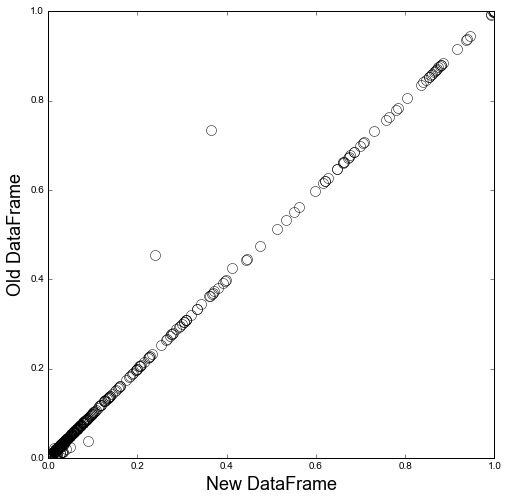

In [9]:
plt.figure(figsize=(8,8))
for x in set(ALL.ALLELE_ID[(ALL.TIME<12)]):
    try:
        plt.plot(ALL.FREQUENCY[(ALL.ALLELE_ID==x)], 
                 ALL_old.FREQ[(ALL_old.ALLELE_ID==x)], 
                 'o', ms=10, mec='black', mfc='none')
    except:
        print(x)
plt.xlabel('New DataFrame', size=18)
plt.ylabel('Old DataFrame', size=18)

Most are fine, some are off... print out the discrepancies

In [8]:
for x in set(ALL.ALLELE_ID[ALL.TIME<12]):
    try:
        #Check the frequency is consistent
        _delta = float(ALL.FREQUENCY[ALL.ALLELE_ID==x])\
                -float(ALL_old.FREQ[ALL_old.ALLELE_ID==x])
        #Get rid of any floating point differences
        _delta = np.round(_delta, decimals=4)
        #Find problematic alleles
        if _delta!=0: 
            print(x,_delta)
    except:
        print('Problematic allele:{}'.format(x))

Patient12_0_1187603 0.0103
Patient12_0_4139490 0.0131
Patient12_0_3597972 0.0097
Patient12_0_4138591 0.0149
Patient04_4_3073833 -0.2149
Patient12_0_779296 0.0009
Patient12_0_3689763 0.0527
Patient12_0_3564850 -0.013
Problematic allele:Patient12_0_1225354
Patient12_0_1206 0.0217
Patient12_0_4138284 0.0096
Patient12_0_2962443 0.0187
Patient12_0_3347797 0.0263
Patient04_4_3530928 -0.3688
Patient12_0_4138960 0.0193
Patient12_0_779193 0.0051
Patient12_0_2391568 -0.0088
Patient12_0_1543917 0.0041
Patient12_0_4138378 0.0118
Patient12_0_1688966 0.0155
Patient12_0_235823 0.0031
Patient12_0_3271395 0.0121
Patient12_0_3222366 0.0197


OK, this is basically fine. The issues come from an old coding error in Patient 4 (I added up the frequencies of the two samples by mistake) and then variation between the merge and S1 samples of Patient 12. All the discrepancies therefore come from the way I chose to treat the samples differently.

### Plot the distribution of allele frequencies

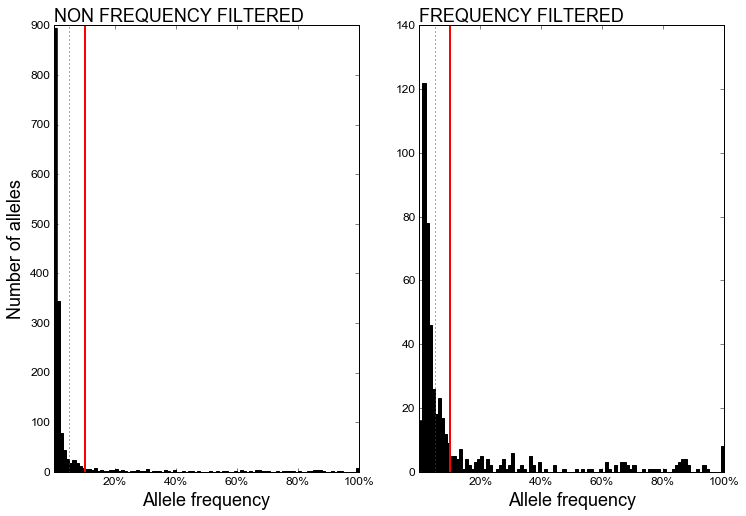

In [4]:
plt.figure('SFS', figsize=(12,8))
plt.subplot(122)
plt.hist(np.array(ALL.FREQUENCY[(ALL.TIME<12)]), bins=np.arange(0,1.01,0.01), 
         label=r'$M.tuberculosis$ - TB patients', 
         color='black')
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.yticks(size=12)
plt.xlabel('Allele frequency', size=18)
plt.vlines(0.05,0,140,colors='red', linestyles='dotted')
plt.vlines(0.1,0,140,colors='red', lw=2)
plt.title('FREQUENCY FILTERED', loc='left', size=18)

plt.subplot(121)
plt.hist(np.array(ALL_old.FREQ), bins=np.arange(0,1.01,0.01), 
         label=r'$M.tuberculosis$ - TB patients', 
         color='black')
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.yticks(size=12)
plt.ylabel('Number of alleles', size=18)
plt.xlabel('Allele frequency', size=18)
plt.vlines(0.05,0,900,colors='red', linestyles='dotted')
plt.vlines(0.1,0,900,colors='red', lw=2)
plt.title('NON FREQUENCY FILTERED', loc='left', size=18)
#plt.savefig('../Figures/160113_Folded_SFS_TBonly.pdf')

Clearly less extreme than before, however still very similar in outcome. Let's have a look at the distribution of alleles across the genome.

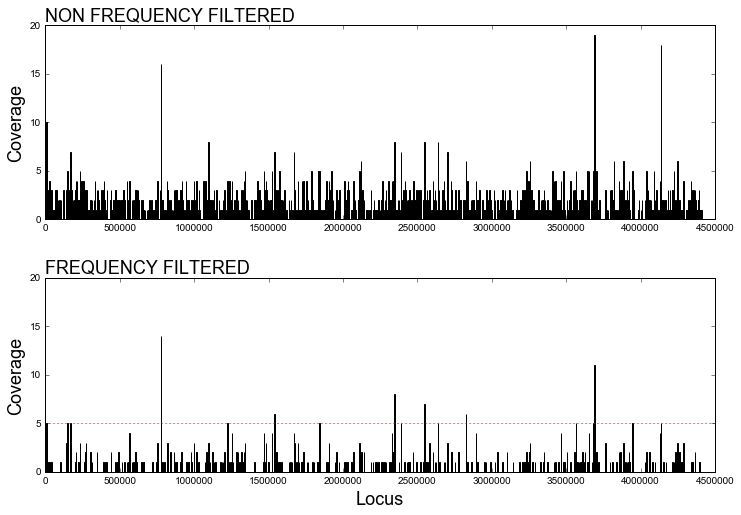

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.title('NON FREQUENCY FILTERED', loc='left', size=18)
plt.hist(list(ALL_old.LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.ylabel('Coverage', size=18)
plt.ylim(0,20)

plt.subplot(212)
plt.title('FREQUENCY FILTERED', loc='left', size=18)
plt.hist(list(ALL.LOCUS[(ALL.TIME<12)]), bins=np.arange(0,4.5e6,4000), color='black')
plt.xlabel('Locus', size=18)
plt.ylabel('Coverage', size=18)
plt.ylim(0,20)
plt.hlines(5,0,4.5e6,colors='red',linestyles='dotted')
plt.subplots_adjust(hspace=0.3)

There are a couple of regions that still have several mutations. Let's identify those with 5+ loci being affected.

In [12]:
c,b = np.histogram(list(ALL.LOCUS[(ALL.TIME<12)]), bins=np.arange(0,4.5e6,4000))
b[c>5]

array([  776000.,  1540000.,  2344000.,  2548000.,  2824000.,  3688000.])

In [58]:
ALL[(ALL.LOCUS[(ALL.TIME<12)]>776000)&(ALL.LOCUS[(ALL.TIME<12)]<780000)]

,FREQUENCY,GENE,LOCUS,LOG_FREQ,NON_EFFICACIOUS,PATIENT_ID,RESISTANCE,SNP_TYPE,TIME,TRANSITION,WT_CODON,ALLELE_ID
245,0.0366,Rv0678,779193,-3.307707,1,Patient12,MDR,NSY,0,0,AGC,Patient12_0_779193
246,0.0076,Rv0678,779296,-4.879607,1,Patient12,MDR,NSY,0,1,GGC,Patient12_0_779296
266,0.0572,Rv0678,779193,-2.861201,1,Patient12,MDR,NSY,2,0,AGC,Patient12_2_779193
267,0.0165,Rv0678,779296,-4.104395,1,Patient12,MDR,NSY,2,1,GGC,Patient12_2_779296
273,0.0333,Rv0678,779215,-3.402198,1,Patient12,MDR,NSY,2,0,CAA,Patient12_2_779215
279,0.0195,Rv0678,779193,-3.937341,1,Patient12,MDR,NSY,4,0,AGC,Patient12_4_779193
284,0.0112,Rv0678,779215,-4.491842,1,Patient12,MDR,NSY,4,0,CAA,Patient12_4_779215
289,0.0219,Rv0678,779193,-3.821269,1,Patient12,MDR,NSY,6,0,AGC,Patient12_6_779193
290,0.0196,Rv0678,779296,-3.932226,1,Patient12,MDR,NSY,6,1,GGC,Patient12_6_779296
296,0.0139,Rv0678,779215,-4.275866,1,Patient12,MDR,NSY,6,0,CAA,Patient12_6_779215


Almost all mutations in Patient 12, all NSY in Rv0678. This is MmpR, which controls the expression of MmpS/L4 both involved in BDQ resistance as well as CFZ cross-resistance. This patient received CFZ treatment, and clearly had small subsets of CFZ resistant strains. Although none swept.

Large number of mutations comes from longitudinal data.

In [60]:
ALL[(ALL.LOCUS[(ALL.TIME<12)]>1540000)&(ALL.LOCUS[(ALL.TIME<12)]<1544000)]

,FREQUENCY,GENE,LOCUS,LOG_FREQ,NON_EFFICACIOUS,PATIENT_ID,RESISTANCE,SNP_TYPE,TIME,TRANSITION,WT_CODON,ALLELE_ID
249,0.0291,Rv1371,1543917,-3.537017,1,Patient12,MDR,SYN,0,1,CTG,Patient12_0_1543917
269,0.0465,Rv1371,1543917,-3.068303,1,Patient12,MDR,SYN,2,1,CTG,Patient12_2_1543917
281,0.0381,Rv1371,1543917,-3.267541,1,Patient12,MDR,SYN,4,1,CTG,Patient12_4_1543917
292,0.0449,Rv1371,1543917,-3.103317,1,Patient12,MDR,SYN,6,1,CTG,Patient12_6_1543917
310,0.0278,Rv1371,1543917,-3.582719,1,Patient12,MDR,SYN,8,1,CTG,Patient12_8_1543917
383,0.0423,Rv1368,1541367,-3.162968,1,Patient09,MDR,SYN,0,1,CCC,Patient09_0_1541367


Stable minor variant in Rv1371 Patient 12.

In [67]:
ALL[(ALL.LOCUS[(ALL.TIME<12)]>2344000)&(ALL.LOCUS[(ALL.TIME<12)]<2348000)]

,FREQUENCY,GENE,LOCUS,LOG_FREQ,NON_EFFICACIOUS,PATIENT_ID,RESISTANCE,SNP_TYPE,TIME,TRANSITION,WT_CODON,ALLELE_ID
53,0.0563,Rv2090,2347614,-2.877061,0,Patient02,DS,NSY,4,0,GTG,Patient02_4_2347614
54,0.0660,Rv2090,2347615,-2.718101,0,Patient02,DS,SYN,4,0,GTG,Patient02_4_2347615
205,0.0487,Rv2090,2347614,-3.022076,1,Patient11,MDR,NSY,8,0,GTG,Patient11_8_2347614
206,0.0396,Rv2090,2347615,-3.228926,1,Patient11,MDR,SYN,8,0,GTG,Patient11_8_2347615
221,0.0577,Rv2090,2347614,-2.852498,0,Patient03,DS,NSY,6,0,GTG,Patient03_6_2347614
222,0.0638,Rv2090,2347615,-2.752002,0,Patient03,DS,SYN,6,0,GTG,Patient03_6_2347615
489,0.0369,Rv2090,2347614,-3.299544,1,Patient10,MDR,NSY,6,0,GTG,Patient10_6_2347614
490,0.0369,Rv2090,2347615,-3.299544,1,Patient10,MDR,SYN,6,0,GTG,Patient10_6_2347615


This looks like a noisy locus, notice that it is always the same two loci affected in tandem in all patients. This is probably a technical issue. 
<strong>Manually remove.</strong>

In [62]:
ALL[(ALL.LOCUS[(ALL.TIME<12)]>2548000)&(ALL.LOCUS[(ALL.TIME<12)]<2552000)]

,FREQUENCY,GENE,LOCUS,LOG_FREQ,NON_EFFICACIOUS,PATIENT_ID,RESISTANCE,SNP_TYPE,TIME,TRANSITION,WT_CODON,ALLELE_ID
80,0.6197,Rv2280,2551722,-0.478520,0,Patient07,Hr,SYN,0,1,CTG,Patient07_0_2551722
84,0.8051,Rv2280,2551722,-0.216789,0,Patient07,Hr,SYN,2,1,CTG,Patient07_2_2551722
97,0.6773,Rv2280,2551722,-0.389641,0,Patient07,Hr,SYN,4,1,CTG,Patient07_4_2551722
108,1.0000,Rv2280,2551722,0.000000,0,Patient07,Hr,SYN,6,1,CTG,Patient07_6_2551722
117,0.7574,Rv2280,2551722,-0.277864,0,Patient07,Hr,SYN,8,1,CTG,Patient07_8_2551722
448,0.2286,Rv2280,2551803,-1.475782,1,Patient10,MDR,NSY,0,1,GTC,Patient10_0_2551803
493,0.0873,Rv2280,2551803,-2.438405,1,Patient10,MDR,NSY,8,1,GTC,Patient10_8_2551803


Stable minor variant in Patient07 and a semi-stable minor variant in Patient 10. Not known what this protien does.

In [63]:
ALL[(ALL.LOCUS[(ALL.TIME<12)]>2824000)&(ALL.LOCUS[(ALL.TIME<12)]<2828000)]

,FREQUENCY,GENE,LOCUS,LOG_FREQ,NON_EFFICACIOUS,PATIENT_ID,RESISTANCE,SNP_TYPE,TIME,TRANSITION,WT_CODON,ALLELE_ID
326,0.1839,Rv2510c,2827042,-1.693363,0,Patient05,DS,SYN,0,1,CGG,Patient05_0_2827042
335,0.6270,Rv2510c,2827042,-0.466809,0,Patient05,DS,SYN,2,1,CGG,Patient05_2_2827042
343,0.1151,Rv2510c,2827042,-2.161954,0,Patient05,DS,SYN,4,1,CGG,Patient05_4_2827042
350,0.6166,Rv2510c,2827042,-0.483535,0,Patient05,DS,SYN,6,1,CGG,Patient05_6_2827042
356,0.0601,Rv2510c,2826798,-2.811745,0,Patient05,DS,NSY,6,1,CGC,Patient05_6_2826798
359,0.8685,Rv2510c,2827042,-0.140988,0,Patient05,DS,SYN,8,1,CGG,Patient05_8_2827042


Stable minor variant in one patient. 

In [64]:
ALL[(ALL.LOCUS[(ALL.TIME<12)]>3688000)&(ALL.LOCUS[(ALL.TIME<12)]<3692000)]

,FREQUENCY,GENE,LOCUS,LOG_FREQ,NON_EFFICACIOUS,PATIENT_ID,RESISTANCE,SNP_TYPE,TIME,TRANSITION,WT_CODON,ALLELE_ID
258,0.0903,Rv3303c,3689763,-2.404618,1,Patient12,MDR,SYN,0,1,GCC,Patient12_0_3689763
272,0.0155,Rv3303c,3689763,-4.166915,1,Patient12,MDR,SYN,2,1,GCC,Patient12_2_3689763
276,0.0156,Rv3303c,3689529,-4.160484,1,Patient12,MDR,SYN,2,1,CTG,Patient12_2_3689529
283,0.0347,Rv3303c,3689763,-3.361016,1,Patient12,MDR,SYN,4,1,GCC,Patient12_4_3689763
285,0.0216,Rv3303c,3689529,-3.835062,1,Patient12,MDR,SYN,4,1,CTG,Patient12_4_3689529
295,0.0925,Rv3303c,3689763,-2.380547,1,Patient12,MDR,SYN,6,1,GCC,Patient12_6_3689763
297,0.2795,Rv3303c,3689529,-1.274753,1,Patient12,MDR,SYN,6,1,CTG,Patient12_6_3689529
303,0.9375,Rv3303c-Rv3304,3690947,-0.064539,1,Patient12,MDR,IGR,6,1,-,Patient12_6_3690947
313,0.0641,Rv3303c,3689763,-2.747311,1,Patient12,MDR,SYN,8,1,GCC,Patient12_8_3689763
315,0.0169,Rv3303c,3689529,-4.080442,1,Patient12,MDR,SYN,8,1,CTG,Patient12_8_3689529


Two stable minor variant in lpdA an upstream IGR variant that may have arisen from the expansion of an unrelated clone. These are upstream of glpD2 and corroborate a large number of glpK mutations. May represent XDR adaptation.

Final scrouple, let me re-do this with a narrower window (500bp) with a slightly lower cutoff.

In [71]:
c,b = np.histogram(list(ALL.LOCUS[(ALL.TIME<12)]), bins=np.arange(0,4.5e6,500))
b[c>4]

array([    7500.,   779000.,  1225000.,  1543500.,  1842500.,  2347500.,
        2551500.,  2637000.,  2827000.,  3564500.,  3683500.,  3689500.,
        3945000.])

In [81]:
ALL[(ALL.LOCUS[(ALL.TIME<12)]>3945000)&(ALL.LOCUS[(ALL.TIME<12)]<3945500)]

,FREQUENCY,GENE,LOCUS,LOG_FREQ,NON_EFFICACIOUS,PATIENT_ID,RESISTANCE,SNP_TYPE,TIME,TRANSITION,WT_CODON,ALLELE_ID
95,0.0197,CFBS_3727-CFBS_3728,3945254,-3.927137,0,Patient07,Hr,IGR,2,1,-,Patient07_2_3945254
102,0.0363,CFBS_3727-CFBS_3728,3945236,-3.315938,0,Patient07,Hr,IGR,4,0,-,Patient07_4_3945236
103,0.0295,CFBS_3727-CFBS_3728,3945237,-3.523365,0,Patient07,Hr,IGR,4,0,-,Patient07_4_3945237
104,0.0401,CFBS_3727-CFBS_3728,3945240,-3.216379,0,Patient07,Hr,IGR,4,0,-,Patient07_4_3945240
105,0.1340,CFBS_3727-CFBS_3728,3945244,-2.009915,0,Patient07,Hr,IGR,4,0,-,Patient07_4_3945244


Summary of the above loci:
- 7500-8000 gyrA mutations in Patient 10 (expected)
- 779000-779500: MmpR minor alleles (NSY) in Patient 12
- 1225000-1225500: stable minor NSY allele (Rv1097c) in Patient 12
- 1543500-1544000: stable minor SYN allele (Rv1371) in Patient 12
- 1842500-1843000: stable minor SYN allele (Rv1636) in Patient 05
- 2347500-2348000: <strong>NOISE ALLELE IN Rv2090 (2347614&2347615, DELETE)</strong>
- 2551500-2552000: minor alleles in Rv2280
- 2637000-2637000: <strong>NOISE ALLELE IN Rv2355-Rv2356c (2637298&2637459, DELETE)</strong>
- 2827000-2827500: stable minor SYN allele (Rv2510c) in Patient 05
- 3564500-3565000: stable minor NSY allele (Rv3195) in Patient 12
- 3683500-3684000: semi-stable minor IGR allele in Patient 12 (CFBS3494-CFBS3495)
- 3689500-3690000: stable minor SYN alleles (Rv3303c) in Patient 12
- 3945000-3945500: plethora of minor IGR alleles in Patient 07 (CFBS3727-CFBS3728). Not sure what to make of this.

Integrated all of this information into:

> 4_allele_data_polishing.py

The dataframe is then used to update the nd.array as well. Outputs are in data/processed: 
- ALLELE_data.csv,
- ALLELE_info.pkl

In [31]:
PROCESSED_PATH = '../data/processed/'

ALL = pd.read_csv('{}ALLELE_data.csv'.format(PROCESSED_PATH), index_col=0)
PATIENT_DATA = pickle.load(open('{}ALLELE_info.pkl'.format(PROCESSED_PATH),'rb'))

### SFS re-plot
Plot the SFS as well as a CDF of the frequency distribution to show exactly how skewed towards the lower frequences the data are. The aim is to generate the final publication plot to be used in the paper.

(0, 1.05)

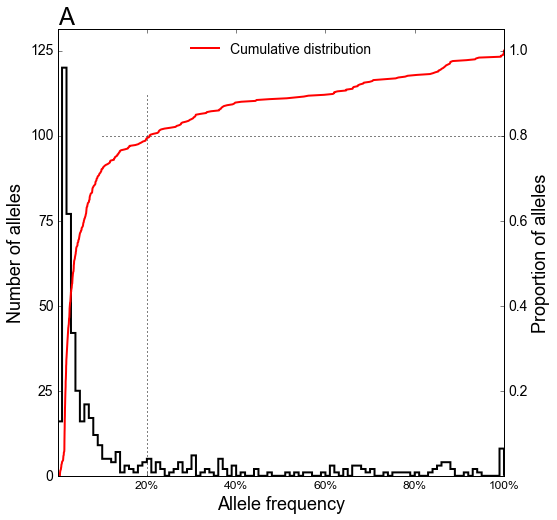

In [4]:
plt.figure('SFS', figsize=(8,8))
plt.hist(np.array(ALL.FREQUENCY[(ALL.TIME<12)]), bins=np.arange(0,1.01,0.01), 
         label=r'$M.tuberculosis$ - TB patients', 
         histtype='step',
         color='black', lw=2)
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.yticks(np.arange(0,150,25),size=14)
plt.ylim(0,131.25)
plt.xlabel('Allele frequency', size=18)
plt.title('A', loc='left', size=24)

plt.ylabel('Number of alleles', size=18)
plt.twinx()
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)])),
         '-',
         label='Cumulative distribution',
         color='red',lw=2)
plt.ylabel('Proportion of alleles', size=18)
plt.yticks(np.arange(0.2,1.2,0.2),size=14)
plt.legend(frameon=False, fontsize=14, loc=9)
plt.vlines(0.2,0,0.9,colors='black', linestyles='dotted')
plt.hlines(0.8,0.1,1,colors='black', linestyles='dotted')
plt.ylim(0,1.05)

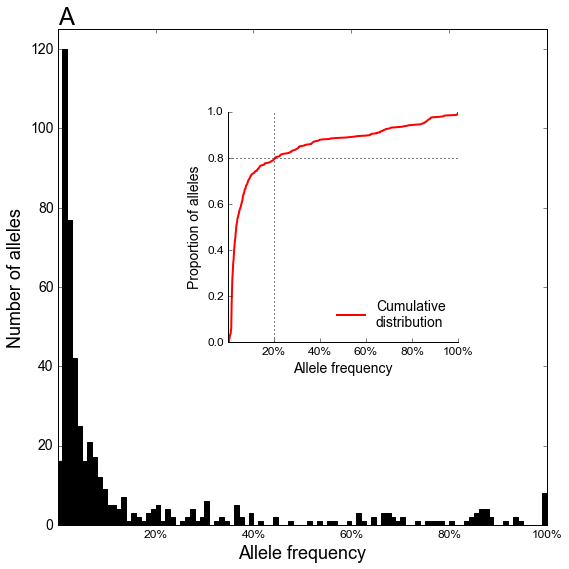

In [5]:
plt.figure('SFS', figsize=(8,8))
plt.hist(np.array(ALL.FREQUENCY[(ALL.TIME<12)]), bins=np.arange(0,1.01,0.01), 
         label=r'$M.tuberculosis$ - TB patients', 
         color='black')
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.yticks(size=14)
plt.xlabel('Allele frequency', size=18)
plt.ylabel('Number of alleles', size=18)
plt.title('A', loc='left', size=24)
plt.ylim(0,125)

#Add inset
a = plt.axes([.4, .4, .4, .4], aspect='equal')
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)])), 
         '-', label='Cumulative\ndistribution',
         color='red',lw=2)
plt.ylabel('Proportion of alleles', size=14)
plt.xlabel('Allele frequency', size=14)
plt.yticks(size=12)
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.legend(frameon=False, fontsize=14, loc=4)
plt.vlines(0.2,0,1,colors='black', linestyles='dotted')
plt.hlines(0.8,0,1,colors='black', linestyles='dotted')
# Hide the right and top spines
a.spines['right'].set_visible(False)
a.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
a.yaxis.set_ticks_position('left')
a.xaxis.set_ticks_position('bottom')

plt.tight_layout()

#plt.savefig('../reports/figures/3_SFS.pdf')
#plt.savefig('../reports/figures/3_SFS.png',dpi=300)

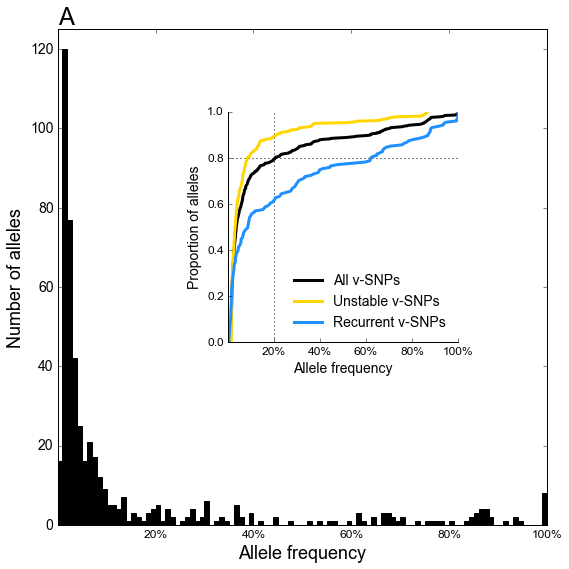

In [12]:
plt.figure('SFS', figsize=(8,8))
plt.hist(np.array(ALL.FREQUENCY[(ALL.TIME<12)]), bins=np.arange(0,1.01,0.01), 
         label=r'$M.tuberculosis$ - TB patients', 
         color='black')
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.yticks(size=14)
plt.xlabel('Allele frequency', size=18)
plt.ylabel('Number of alleles', size=18)
plt.title('A', loc='left', size=24)
plt.ylim(0,125)

#Add inset
a = plt.axes([.4, .4, .4, .4], aspect='equal')
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)])), 
         '-', label='All v-SNPs',
         color='black',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==0)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==0)])), 
         '-', label='Unstable v-SNPs',
         color='gold',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==1)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==1)])), 
         '-', label='Recurrent v-SNPs',
         color='dodgerblue',lw=3)
plt.ylabel('Proportion of alleles', size=14)
plt.xlabel('Allele frequency', size=14)
plt.yticks(size=12)
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.legend(frameon=False, fontsize=14, loc=4)
plt.vlines(0.2,0,1,colors='black', linestyles='dotted')
plt.hlines(0.8,0,1,colors='black', linestyles='dotted')
# Hide the right and top spines
a.spines['right'].set_visible(False)
a.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
a.yaxis.set_ticks_position('left')
a.xaxis.set_ticks_position('bottom')

plt.tight_layout()

#plt.savefig('../reports/figures/3_SFS_Alt.pdf')
#plt.savefig('../reports/figures/3_SFS_Alt.png',dpi=300)

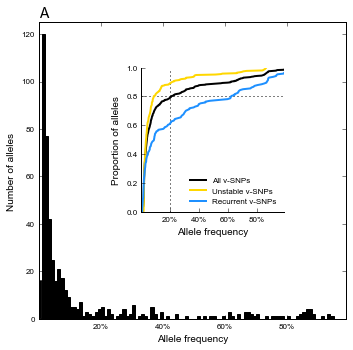

In [36]:
plt.figure('SFS', figsize=(5,5))
plt.hist(np.array(ALL.FREQUENCY[(ALL.TIME<12)]), bins=np.arange(0,1.01,0.01), 
         label=r'$M.tuberculosis$ - TB patients', 
         color='black')
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=tick_size)
plt.yticks(size=tick_size)
plt.xlabel('Allele frequency', size=label_size)
plt.ylabel('Number of alleles', size=label_size)
plt.title('A', loc='left', size=14)
plt.ylim(0,125)
plt.xlim(0,0.99)

#Add inset
a = plt.axes([.4, .4, .4, .4], aspect='equal')
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)])), 
         '-', label='All v-SNPs',
         color='black',lw=2)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==0)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==0)])), 
         '-', label='Unstable v-SNPs',
         color='gold',lw=2)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==1)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==1)])), 
         '-', label='Recurrent v-SNPs',
         color='dodgerblue',lw=2)
plt.ylabel('Proportion of alleles', size=label_size)
plt.xlabel('Allele frequency', size=label_size)
plt.yticks(size=tick_size)
plt.xticks(np.arange(.2,1,.2),['20%','40%','60%','80%'], size=tick_size)
plt.xlim(0,0.99)
plt.legend(frameon=False, fontsize=text_size, loc=4)
plt.vlines(0.2,0,1,colors='black', linestyles='dotted')
plt.hlines(0.8,0,1,colors='black', linestyles='dotted')
# Hide the right and top spines
a.spines['right'].set_visible(False)
a.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
a.yaxis.set_ticks_position('left')
a.xaxis.set_ticks_position('bottom')

plt.tight_layout()

plt.savefig('../reports/figures/3_SFS_Alt.pdf')
#plt.savefig('../reports/figures/3_SFS_Alt.png',dpi=600)

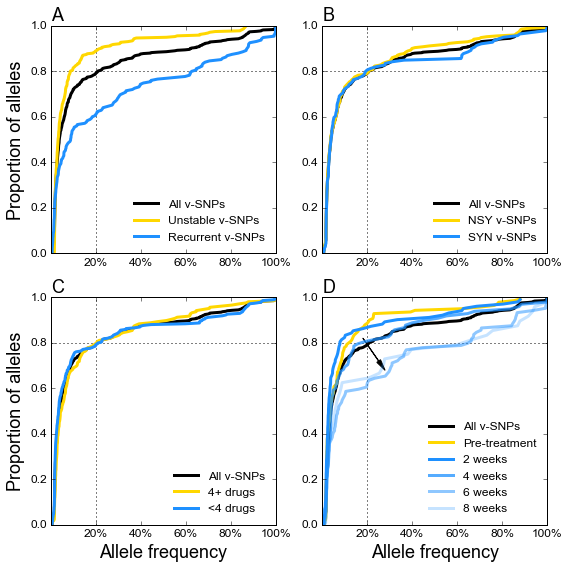

In [64]:
plt.figure('SFS', figsize=(8,8))
plt.subplot(221)
plt.title('A', size=18, loc='left')
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)]), endpoint=False), 
         '-', label='All v-SNPs',
         color='black',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==0)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==0)]), endpoint=False), 
         '-', label='Unstable v-SNPs',
         color='gold',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==1)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==1)]), endpoint=False), 
         '-', label='Recurrent v-SNPs',
         color='dodgerblue',lw=3)
plt.ylabel('Proportion of alleles', size=18)
#plt.xlabel('Allele frequency', size=14)
plt.yticks(size=12)
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.legend(frameon=False, fontsize=12, loc=4)
plt.vlines(0.2,0,1,colors='black', linestyles='dotted')
plt.hlines(0.8,0,1,colors='black', linestyles='dotted')

plt.subplot(222)
plt.title('B', size=18, loc='left')
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)])), 
         '-', label='All v-SNPs',
         color='black',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.SNP_TYPE=='NSY')])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.SNP_TYPE=='NSY')])), 
         '-', label='NSY v-SNPs',
         color='gold',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.SNP_TYPE=='SYN')])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.SNP_TYPE=='SYN')])), 
         '-', label='SYN v-SNPs',
         color='dodgerblue',lw=3)
#plt.ylabel('Proportion of alleles', size=14)
#plt.xlabel('Allele frequency', size=14)
plt.yticks(size=12)
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.legend(frameon=False, fontsize=12, loc=4)
plt.vlines(0.2,0,1,colors='black', linestyles='dotted')
plt.hlines(0.8,0,1,colors='black', linestyles='dotted')

plt.subplot(223)
plt.title('C', size=18, loc='left')
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)])), 
         '-', label='All v-SNPs',
         color='black',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.NON_EFFICACIOUS==0)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.NON_EFFICACIOUS==0)])), 
         '-', label='4+ drugs',
         color='gold',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.NON_EFFICACIOUS==1)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.NON_EFFICACIOUS==1)])), 
         '-', label='<4 drugs',
         color='dodgerblue',lw=3)
plt.ylabel('Proportion of alleles', size=18)
plt.xlabel('Allele frequency', size=18)
plt.yticks(size=12)
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.legend(frameon=False, fontsize=12, loc=4)
plt.vlines(0.2,0,1,colors='black', linestyles='dotted')
plt.hlines(0.8,0,1,colors='black', linestyles='dotted')

plt.subplot(224)
plt.title('D', size=18, loc='left')
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)])), 
         '-', label='All v-SNPs',
         color='black',lw=3)
#plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==0)])), 
#         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==0)])), 
#         '-', label='Pre-treatment',
#         color='gold',lw=3)
#plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.TIME>0)])), 
#         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.TIME>0)])),
#         '-', label='Post-treatment',
#         color='dodgerblue',lw=3)
#plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
#         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)]), endpoint=False), 
#         '-', label='All v-SNPs',
#         color='black',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==0)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==0)]), endpoint=False), 
         '-', label='Pre-treatment',
         color='gold',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==2)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==2)]), endpoint=False), 
         '-', label='2 weeks',
         color='dodgerblue',lw=3, alpha=1)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==4)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==4)]), endpoint=False), 
         '-', label='4 weeks',
         color='dodgerblue',lw=3, alpha=0.75)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==6)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==6)]), endpoint=False), 
         '-', label='6 weeks',
         color='dodgerblue',lw=3, alpha=0.5)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==8)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==8)]), endpoint=False), 
         '-', label='8 weeks',
         color='dodgerblue',lw=3, alpha=0.25)
plt.arrow(0.18, 0.82, .07, -.1, head_width=0.02, head_length=0.05, fc='k', ec='k')
#plt.ylabel('Proportion of alleles', size=14)
plt.xlabel('Allele frequency', size=18)
plt.yticks(size=12)
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.legend(frameon=False, fontsize=12, loc=4)
plt.vlines(0.2,0,1,colors='black', linestyles='dotted')
plt.hlines(0.8,0,1,colors='black', linestyles='dotted')

plt.tight_layout()

#plt.savefig('../reports/figures/3_Supplementary_SFS.pdf')
#plt.savefig('../reports/figures/3_Supplementray_SFS.png',dpi=300)

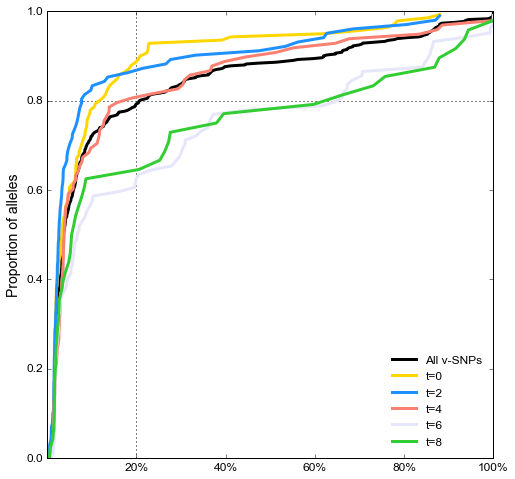

In [7]:
plt.figure('SFS', figsize=(8,8))
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME<12)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME<12)]), endpoint=False), 
         '-', label='All v-SNPs',
         color='black',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==0)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==0)]), endpoint=False), 
         '-', label='t=0',
         color='gold',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==2)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==2)]), endpoint=False), 
         '-', label='t=2',
         color='dodgerblue',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==4)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==4)]), endpoint=False), 
         '-', label='t=4',
         color='salmon',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==6)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==6)]), endpoint=False), 
         '-', label='t=6',
         color='lavender',lw=3)
plt.plot(sorted(list(ALL.FREQUENCY[(ALL.TIME==8)])), 
         np.linspace(0,1,num=len(ALL.FREQUENCY[(ALL.TIME==8)]), endpoint=False), 
         '-', label='t=8',
         color='limegreen',lw=3)
plt.ylabel('Proportion of alleles', size=14)
#plt.xlabel('Allele frequency', size=14)
plt.yticks(size=12)
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.legend(frameon=False, fontsize=12, loc=4)
plt.vlines(0.2,0,1,colors='black', linestyles='dotted')
plt.hlines(0.8,0,1,colors='black', linestyles='dotted')

In [11]:
sum(ALL.FREQUENCY[(ALL.TIME<12)&(ALL.RECURRENT==0)]<0.2)

283

Main takehome stays the same. I think the cumulative distribution visually corroborates the notion that most of the genetic heterogeneity is driven by minor clones as it shows that <strong>80% of the vSNPs have a frequency of less than 20%</strong>.

## Allele frequency and stability
Some of the detected vSNPs are stable across time points while other are not. Run a logistic regression to see how good a predictor of stability is allele frequency.

### Classify vSNPs as re-current

In [32]:
RECURRENT_vSNP = {}

for patient in PATIENT_DATA['PATIENTS']:
    RECURRENT_vSNP[patient] = []
    for k,v in Counter(ALL.LOCUS[(ALL.PATIENT_ID==patient)]).items():
        if v>1: RECURRENT_vSNP[patient].append(k)
            
ALL['RECURRENT'] = [int(x in RECURRENT_vSNP[y]) for (x,y) in zip(ALL.LOCUS,ALL.PATIENT_ID)]

Perform a logistic regression (note that this is imperfect, as we don't have a Mixed Effect logistic regression model function in python) to see whether the allele frequency at time 0 influences the ultimate recurrence of an allele over time - i.e. stability.

### Logistic regression

In [110]:
model = sm.GLM.from_formula('RECURRENT ~ FREQUENCY', ALL[ALL.TIME==0], family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              RECURRENT   No. Observations:                  140
Model:                            GLM   Df Residuals:                      138
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -61.559
Date:                Wed, 21 Sep 2016   Deviance:                       123.12
Time:                        16:19:23   Pearson chi2:                     143.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.9804      0.289     -6.844      0.000        -2.548    -1.413
FREQUENCY      6.7937      2.025      3.356      0.0

Looks like it does. Let's have a look at what this actually looks like.

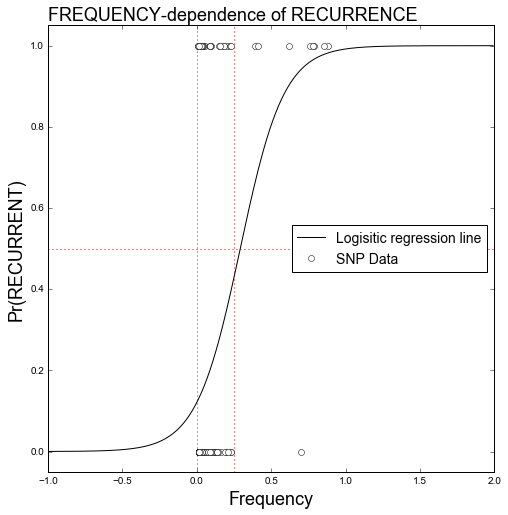

In [127]:
I , B1 = result.params

#Calculate the log-odds of being RECURRENT at each FREQUENCY
LOGODDS = np.arange(-1,2,0.01)*B1+I
#Calculate ODDS
ODDS = np.exp(LOGODDS)
#Calculate Probability
P = ODDS/(1+ODDS)

plt.figure(figsize=(8,8))

plt.plot(np.arange(-1,2,0.01),P,'k-')
plt.plot(ALL.FREQUENCY[ALL.TIME==0], ALL.RECURRENT[ALL.TIME==0], 'wo')
plt.xlabel('Frequency', size=18)
plt.ylabel('Pr(RECURRENT)', size=18)
plt.legend(['Logisitic regression line', 'SNP Data'], loc=5, fontsize=14)
#plt.vlines(800,-0.05,1.05,colors='red',linestyles='dashed')
#plt.hlines(0.05,0,1800,colors='blue',linestyles='dashed')
plt.ylim(-0.05,1.05)
plt.title('FREQUENCY-dependence of RECURRENCE', size=18, loc='left')
plt.vlines(0,-0.05,1.05,linestyles='dotted',colors='red')
plt.vlines(0.25,-0.05,1.05,linestyles='dotted',colors='red')
plt.hlines(0.5,-1,2,linestyles='dotted',colors='red')

I have performed the analysis in R using 'lme4' and 'glmer' to do a mixed effect logistic regression:

> t0 <-ALL$TIME==0

> result <- glmer(RECURRENT ~ FREQUENCY + (1|PATIENT_ID), ALL[t0,], family=binomial)


The calculated parameters were:

> Intercept -2.608

> FREQUENCY 10.136

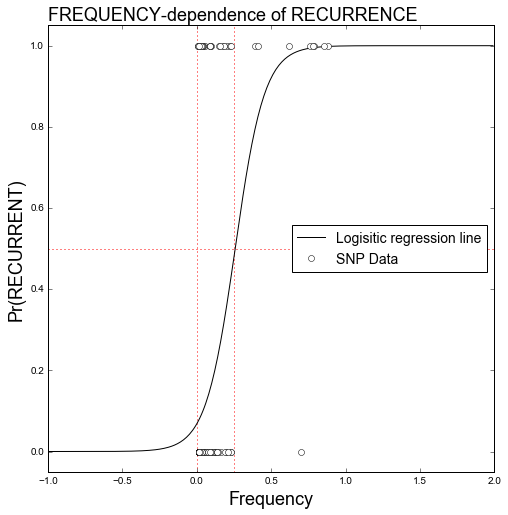

In [126]:
I , B1 = -2.608, 10.136

#Calculate the log-odds of being RECURRENT at each FREQUENCY
LOGODDS = np.arange(-1,2,0.01)*B1+I
#Calculate ODDS
ODDS = np.exp(LOGODDS)
#Calculate Probability
P = ODDS/(1+ODDS)

plt.figure(figsize=(8,8))

plt.plot(np.arange(-1,2,0.01),P,'k-')
plt.plot(ALL.FREQUENCY[ALL.TIME==0], ALL.RECURRENT[ALL.TIME==0], 'wo')
plt.xlabel('Frequency', size=18)
plt.ylabel('Pr(RECURRENT)', size=18)
plt.legend(['Logisitic regression line', 'SNP Data'], loc=5, fontsize=14)
#plt.vlines(800,-0.05,1.05,colors='red',linestyles='dashed')
#plt.hlines(0.05,0,1800,colors='blue',linestyles='dashed')
plt.ylim(-0.05,1.05)
plt.title('FREQUENCY-dependence of RECURRENCE', size=18, loc='left')
plt.vlines(0,-0.05,1.05,linestyles='dotted',colors='red')
plt.vlines(0.25,-0.05,1.05,linestyles='dotted',colors='red')
plt.hlines(0.5,-1,2,linestyles='dotted',colors='red')

Unsurprisingly the higher frequency alleles at the time of start of treatment are more likely to be stable in the population. On the other hand for frequencies between 0-25% the alleles are more likely to be transient than stable. This is also reflected in the overall distribution of alleles: out of 140 vSNPs detected at T=0, 31 were recurrent and 109 were not.

On a tangent (this is probably wrong, but I'm curious), can I use survival analysis statistics to look at this a bit better?

(0, 1.05)

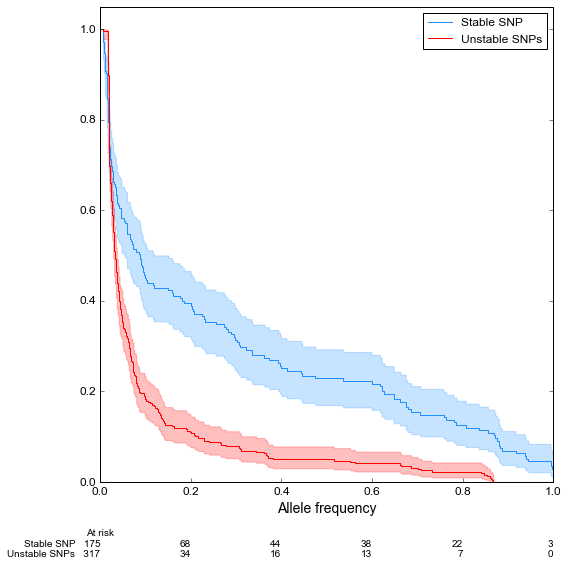

In [22]:
import lifelines as lf
a = ALL[['FREQUENCY','RECURRENT', 'TIME', 'NON_EFFICACIOUS', 'SNP_TYPE']][ALL.TIME<12].copy()
a = a.reset_index(drop=True)
a['E'] = [1 for x in a.index]
E = a['E']
T = a['FREQUENCY']
t = np.linspace(0,1,len(a))
recurrent = a['RECURRENT']==1
treatment = a['TIME']>0
efficacious = a['NON_EFFICACIOUS']==0
nsysnp = a['SNP_TYPE']=='NSY'
synsnp = a['SNP_TYPE']=='SYN'
kmf = lf.KaplanMeierFitter()
kmf.fit(T[recurrent], timeline=t, event_observed=E[recurrent], label='Stable SNP')
ax = kmf.plot(figsize=(8,8),fontsize=12, c='dodgerblue')

kmf2 = lf.KaplanMeierFitter()  
kmf2.fit(T[~recurrent], timeline=t, event_observed=E[~recurrent], label='Unstable SNPs')
kmf2.plot(ax=ax, c="r")
plt.xlabel('Allele frequency',size=14)
lf.plotting.add_at_risk_counts(kmf, kmf2, ax=ax)
plt.ylim(0,1.05)



In [13]:
from lifelines.statistics import logrank_test
results = logrank_test(T[recurrent], T[~recurrent], event_observed_A=E[recurrent], event_observed_B=E[~recurrent])
results.print_summary()

Results
   alpha: 0.95
   test: logrank
   t 0: -1
   null distribution: chi squared
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |             46.133 |      Reject Null    |        True       


(0, 1.05)

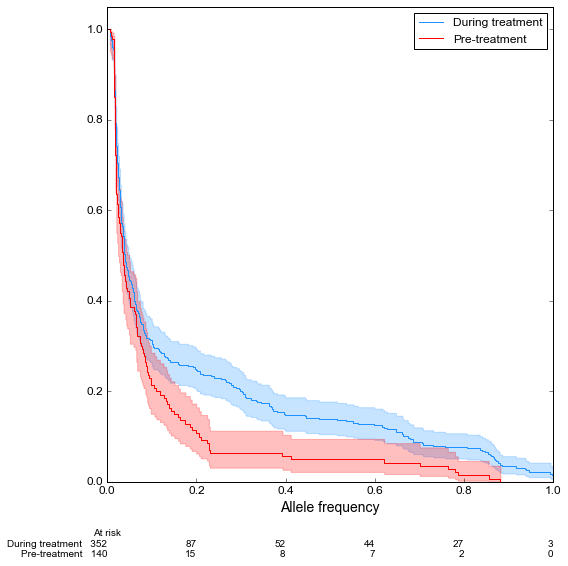

In [14]:
kmf = lf.KaplanMeierFitter()
kmf.fit(T[treatment], timeline=t, event_observed=E[treatment], label='During treatment')
ax = kmf.plot(figsize=(8,8),fontsize=12, c='dodgerblue')

kmf2 = lf.KaplanMeierFitter()  
kmf2.fit(T[~treatment], timeline=t, event_observed=E[~treatment], label='Pre-treatment')
kmf2.plot(ax=ax, c="r")
plt.xlabel('Allele frequency',size=14)
lf.plotting.add_at_risk_counts(kmf, kmf2, ax=ax)
plt.ylim(0,1.05)


In [15]:
results = logrank_test(T[treatment], T[~treatment], event_observed_A=E[treatment], event_observed_B=E[~treatment])
results.print_summary()

Results
   alpha: 0.95
   test: logrank
   t 0: -1
   null distribution: chi squared
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00228 |              9.313 |      Reject Null    |        True       


(0, 1.05)

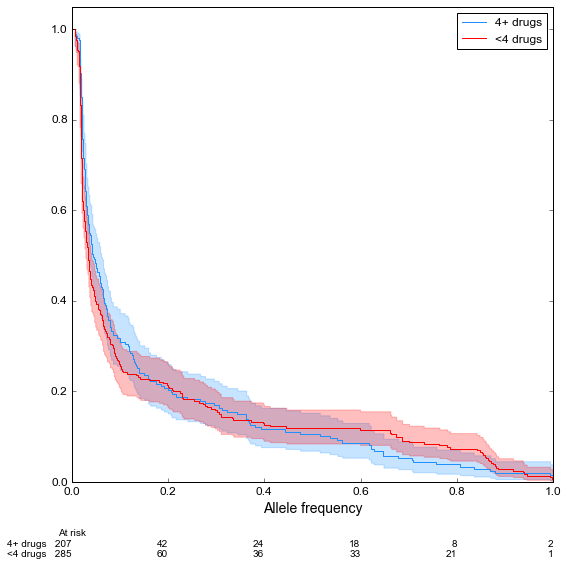

In [21]:
kmf = lf.KaplanMeierFitter()
kmf.fit(T[efficacious], timeline=t, event_observed=E[efficacious], label='4+ drugs')
ax = kmf.plot(figsize=(8,8),fontsize=12, c='dodgerblue')

kmf2 = lf.KaplanMeierFitter()  
kmf2.fit(T[~efficacious], timeline=t, event_observed=E[~efficacious], label='<4 drugs')
kmf2.plot(ax=ax, c="r")
plt.xlabel('Allele frequency',size=14)
lf.plotting.add_at_risk_counts(kmf, kmf2, ax=ax)
plt.ylim(0,1.05)

In [18]:
results = logrank_test(T[efficacious], T[~efficacious], 
                       event_observed_A=E[efficacious], event_observed_B=E[~efficacious])
results.print_summary()

Results
   alpha: 0.95
   test: logrank
   t 0: -1
   null distribution: chi squared
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.44751 |              0.577 |  Cannot Reject Null |       False       


(0, 1.05)

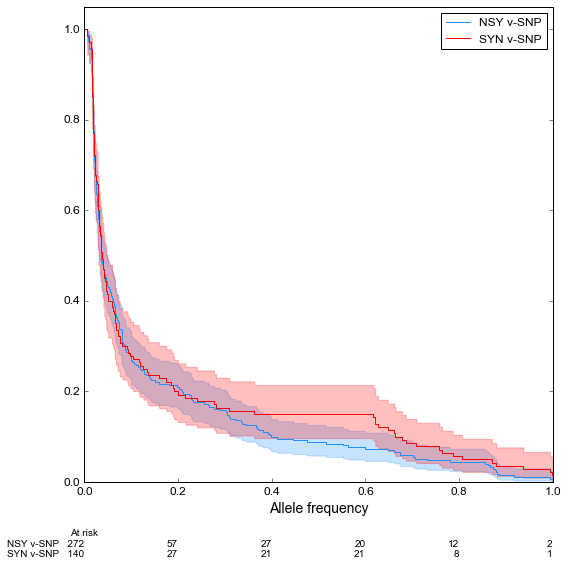

In [27]:
kmf = lf.KaplanMeierFitter()
kmf.fit(T[nsysnp], timeline=t, event_observed=E[nsysnp], label='NSY v-SNP')
ax = kmf.plot(figsize=(8,8),fontsize=12, c='dodgerblue')

kmf2 = lf.KaplanMeierFitter()  
kmf2.fit(T[synsnp], timeline=t, event_observed=E[synsnp], label='SYN v-SNP')
kmf2.plot(ax=ax, c="r")
plt.xlabel('Allele frequency',size=14)
lf.plotting.add_at_risk_counts(kmf, kmf2, ax=ax)
plt.ylim(0,1.05)

In [25]:
results = logrank_test(T[nsysnp], T[synsnp], 
                       event_observed_A=E[nsysnp], event_observed_B=E[synsnp])
results.print_summary()

Results
   alpha: 0.95
   test: logrank
   t 0: -1
   null distribution: chi squared
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.50272 |              0.449 |  Cannot Reject Null |       False       


In [23]:
for time in [0,2,4,6,8]:
    a = ALL[['FREQUENCY','RECURRENT']][ALL.TIME==time].copy()
    a = a.reset_index(drop=True)
    a['E'] = [1 for x in a.index]
    E = a['E']
    T = a['FREQUENCY']
    t = np.linspace(0,1,len(a))
    recurrent = a['RECURRENT']==1
    results = logrank_test(T[recurrent], T[~recurrent], event_observed_A=E[recurrent], event_observed_B=E[~recurrent])
    results.print_summary()

Results
   df: 1
   alpha: 0.95
   null distribution: chi squared
   test: logrank
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |             22.607 |      Reject Null    |        True       
Results
   df: 1
   alpha: 0.95
   null distribution: chi squared
   test: logrank
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.32897 |              0.953 |  Cannot Reject Null |       False       
Results
   df: 1
   alpha: 0.95
   null distribution: chi squared
   test: logrank
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00491 |              7.912 |      Reject Null    |        True       
Results
   df: 1
   alpha: 0.95
   null distribution: chi squared
   test: logrank
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00455 |              8.049 |      Reje

Assuming I can use survival analysis in this case, the inference is the following: stable SNPs have a higher overall frequency and this difference is significant. Re-running the above analysis for each timepoint, I see that this relationship is true for all but one tested timepoint. So what does this mean? Never mind, these analyses are probably not applicable to frequency data...

Taking a more naive approach again and looking specifically at the denisty of these allele frequency distributions:

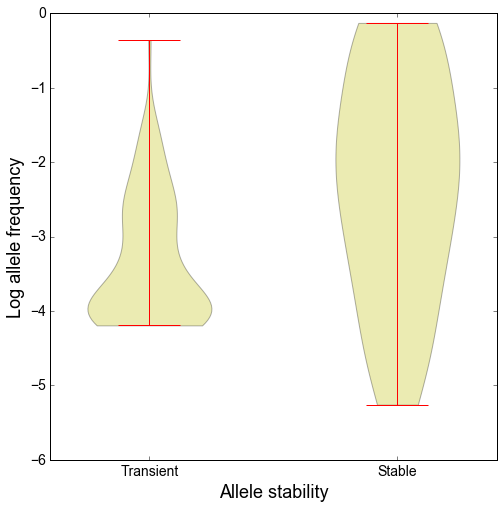

In [24]:
plt.figure('Violin', figsize=(8,8))
plt.violinplot([ALL.LOG_FREQ[(ALL.RECURRENT==0)&(ALL.TIME==0)],
                ALL.LOG_FREQ[(ALL.RECURRENT==1)&(ALL.TIME==0)]])
plt.xticks([1,2],['Transient', 'Stable'],size=14)
plt.yticks(size=14)
plt.ylabel('Log allele frequency', size=18)
plt.xlabel('Allele stability', size=18)

The shape is clearly different, so chances are that the correlation is driven by these high frequency mutations, and for the rest of there is a stochastic mechanism determining their expansion.

Exploring this a bit furtner, patient 12 has 3 samples for t=0. Let's quantify the overlap.

### Patient 12 repeat sampling

In [4]:
P12_T0 = {'S1': [], 
          'S2': [],
          'S3': []}

P12_T0_FREQ = {}

for ind,sample in enumerate(['S1', 'S2', 'S3']):
     for line in open('../data/raw/ANNOTATED_vSNP/1200_{}.annotated'.format(sample)):
            split = line.split('\t')
            if int(split[0]) in list(ALL.LOCUS[(ALL.PATIENT_ID=='Patient12')&(ALL.TIME!=0)])\
            or float(split[3][:-1])>1.5:
                P12_T0[sample].append(int(split[0]))
                if int(split[0]) in P12_T0_FREQ:
                    P12_T0_FREQ[int(split[0])][ind]+=float(split[3][:-1])
                if int(split[0]) not in P12_T0_FREQ:
                    P12_T0_FREQ[int(split[0])]=np.zeros(3)
                    P12_T0_FREQ[int(split[0])][ind]+=float(split[3][:-1])

P12_T0_FREQ = pd.DataFrame(P12_T0_FREQ).T
P12_T0_FREQ['RECURRENT'] = [int(x in list(ALL.LOCUS[(ALL.PATIENT_ID=='Patient12')&
                                                    (ALL.TIME!=0)])) for x in P12_T0_FREQ.index]
P12_T0_FREQ[P12_T0_FREQ.RECURRENT==1]

,0,1,2,RECURRENT
1206,4.07,1.39,0.00,1
235823,3.28,6.21,0.00,1
779193,3.66,5.47,0.95,1
779215,0.00,1.18,0.00,1
779296,0.76,1.71,0.00,1
1225354,0.52,0.97,0.00,1
1543917,2.91,4.32,0.79,1
2191793,0.00,0.00,0.62,1
2391568,1.41,2.81,2.74,1
3564850,41.14,31.74,51.17,1


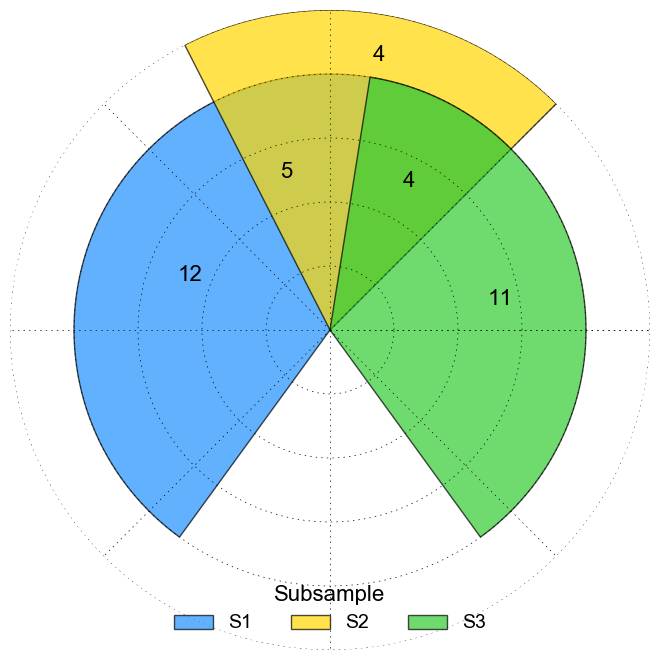

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = [0.25*np.pi, 0.25*np.pi, 1.7*np.pi]
radii = [8,10,8]
width = [21/20*np.pi, 8/20*np.pi, 15/20*np.pi]
bars = ax.bar(theta, radii, width=width, bottom=0.0)
colors = ['dodgerblue', 'gold', 'limegreen']
labels = ['S1','S2','S3']
for label,bar,color in zip(labels, bars, colors):
    bar.set_facecolor(color)
    bar.set_label(label)
    bar.set_alpha(0.7)
#plt.grid(None)
ax.spines['polar'].set_visible(False)
plt.xticks(np.linspace(0,2*np.pi,9),[])
plt.yticks(np.arange(0,12,2),[])
plt.text(np.pi*.45,8.5,'4', fontsize=16)
plt.text(np.pi*.6,5,'5', fontsize=16)
plt.text(np.pi*.35,5,'4', fontsize=16)
plt.text(np.pi*0.05,5,'11', fontsize=16)
plt.text(np.pi*.9,5,'12', fontsize=16)
plt.legend(ncol=3, loc=8, title='Subsample', fontsize=14, frameon=False)
ax.get_legend().get_title().set_fontsize('16')

In [10]:
for subsample in [0,1,2]:
    _a = [x>0 for x in P12_T0_FREQ[subsample]]
    _b = list(P12_T0_FREQ.RECURRENT)
    print(ss.spearmanr(_a,_b))

SpearmanrResult(correlation=0.31598125869132787, pvalue=0.060463322331165116)
SpearmanrResult(correlation=0.63121401607007122, pvalue=3.6643076467806535e-05)
SpearmanrResult(correlation=0.050964719143762563, pvalue=0.76784999295461076)


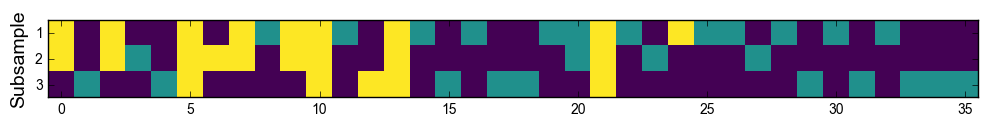

In [5]:
present = np.array(P12_T0_FREQ[[0,1,2]]>0,dtype=int)
recurrent = np.array(P12_T0_FREQ.RECURRENT)

plt.figure(figsize=(12,4))
plt.subplot(211)

plt.imshow( (present+(present.T*recurrent).T).T, interpolation='none', cmap='viridis')
plt.yticks([0,1,2],[1,2,3])
plt.ylabel('Subsample', size=14)


All of the alleles that are present in all samples are also stable over time. Similarly, almost all shared alleles are also stable with the exception of 3347797 (marker 20 above). Clearly though the populations represented in each of the subsamples are re-sampled over the course of treatment. I wonder how many times each gets picked up over the course of treatment.

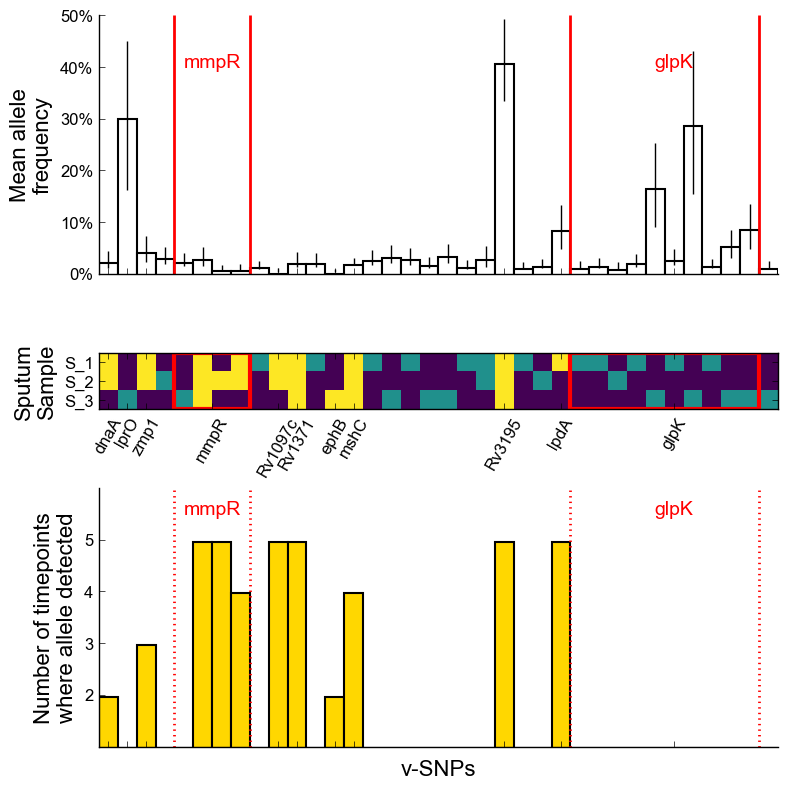

In [51]:
plt.figure(figsize=(8,8))

c=plt.subplot2grid((5,5), (0,0), rowspan=2, colspan=5)

plt.vlines(24.5,0,50,lw=2,colors='red')
plt.vlines(34.5,0,50,lw=2,colors='red')
plt.vlines(3.5,0,50,lw=2,colors='red')
plt.vlines(7.5,0,50,lw=2,colors='red')

plt.bar(np.arange(-0.5,35,1), 
        np.array(P12_T0_FREQ[[0,1,2]].sum(axis=1))/np.array(P12_T0_FREQ[[0,1,2]]>0).sum(axis=1),
        bottom=-.7, width=1, color='white',lw=1.5)
plt.vlines(np.arange(0,35.5,1),
           np.array(P12_T0_FREQ[[0,1,2]].sum(axis=1))/np.array(P12_T0_FREQ[[0,1,2]]>0).sum(axis=1)\
           +np.std(P12_T0_FREQ[[0,1,2]], axis=1),
           np.array(P12_T0_FREQ[[0,1,2]].sum(axis=1))/np.array(P12_T0_FREQ[[0,1,2]]>0).sum(axis=1)\
           -np.std(P12_T0_FREQ[[0,1,2]], axis=1),
          )

plt.ylabel('Mean allele\nfrequency', size=16)
plt.xlim(-.5,35.5)
plt.ylim(0,50)
plt.yticks(np.arange(0,60,10), 
           ['0%', '10%', '20%', '30%', '40%', '50%'],
           size=12)
plt.xticks(np.arange(0,36,5),[])
plt.text(5.5,40,'mmpR',horizontalalignment='center',
         size=14,color='red')
plt.text(30,40,'glpK',horizontalalignment='center',
         size=14,color='red')
c.spines['right'].set_visible(False)
c.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
c.yaxis.set_ticks_position('left')
c.xaxis.set_ticks_position('bottom')

plt.xticks([0,1,2,5.5,9,10,12,13,21,24,30],
           rotation=60,size=12)


plt.subplot2grid((5,5), (2,0), rowspan=1, colspan=5)
plt.imshow( (present+(present.T*recurrent).T).T, aspect='equal', interpolation='none', cmap='viridis')
plt.yticks([0,1,2],['S_1','S_2','S_3'],size=12)
plt.ylabel('Sputum\nSample', size=16)
plt.vlines(24.5,-.50,2.5,lw=3,colors='red')
plt.vlines(34.5,-.50,2.5,lw=3,colors='red')
plt.vlines(3.5,-.50,2.5,lw=3,colors='red')
plt.vlines(7.5,-.50,2.5,lw=3,colors='red')

plt.hlines(-.50,24.5,34.5,lw=3,colors='red')
plt.hlines(2.5,24.5,34.5,lw=3,colors='red')
plt.hlines(-.50,3.5,7.5,lw=3,colors='red')
plt.hlines(2.5,3.5,7.5,lw=3,colors='red')

plt.xlim(-0.5,35.5)
plt.xticks([0,1,2,5.5,9,10,12,13,21,24,30],
           ['dnaA','lprO','zmp1','mmpR','Rv1097c','Rv1371','ephB','mshC','Rv3195','lpdA','glpK'],
           rotation=60,size=12)

d = plt.subplot2grid((5,5), (3,0), rowspan=2, colspan=5)
#count how many times each locus is present in the rest of the timepoints
COUNTINGS = Counter(list(ALL.LOCUS[(ALL.PATIENT_ID=='Patient12')&(ALL.TIME!=0)]))
PROPORTIONS = [COUNTINGS.get(x,0)*20 for x in P12_T0_FREQ.index]

plt.vlines(24.5,0,100,lw=2,colors='red',linestyles='dotted')
plt.vlines(34.5,0,100,lw=2,colors='red',linestyles='dotted')
plt.vlines(3.5,0,100,lw=2,colors='red',linestyles='dotted')
plt.vlines(7.5,0,100,lw=2,colors='red',linestyles='dotted')
plt.bar(np.arange(-0.5,35,1), 
        PROPORTIONS,
        bottom=-.7, width=1, color='gold',lw=1.5)
plt.ylabel('Number of timepoints\nwhere allele detected', size=16)
plt.xlim(-.5,35.5)
plt.ylim(0,100)
plt.yticks(np.arange(20,100,20), 
           ['2', '3', '4', '5'],
           size=12)
plt.xticks(np.arange(0,36,5),[])
plt.text(5.5,90,'mmpR',horizontalalignment='center',
         size=14,color='red')
plt.text(30,90,'glpK',horizontalalignment='center',
         size=14,color='red')
d.spines['right'].set_visible(False)
d.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
d.yaxis.set_ticks_position('left')
d.xaxis.set_ticks_position('bottom')

plt.xticks([0,1,2,5.5,9,10,12,13,21,24,30],
           rotation=60,size=12)

plt.xlabel('v-SNPs', size=16)

plt.tight_layout()

#plt.savefig('../reports/figures/3_P12_resample.pdf')
#plt.savefig('../reports/figures/3_P12_resample',dpi=300)

In [7]:
#Does allele frequency determine weather an allele is shared across samples?
shared = present.sum(1)>1
shared_frequencies = [x for x in np.array(P12_T0_FREQ[[0,1,2]], dtype=float)[shared].flatten() if x>0]
unique_frequencies = [x for x in np.array(P12_T0_FREQ[[0,1,2]], dtype=float)[~shared].flatten() if x>0]

ss.mannwhitneyu(shared_frequencies, unique_frequencies, alternative='two-sided')

MannwhitneyuResult(statistic=288.0, pvalue=0.86433665774458546)

In [21]:
#Does allele frequency determine weather an allele is stable over time?
ss.mannwhitneyu([x for x in np.array(P12_T0_FREQ[[0,1,2]][P12_T0_FREQ.RECURRENT==1], 
                                     dtype=float).flatten() if x>0],
                [x for x in np.array(P12_T0_FREQ[[0,1,2]][P12_T0_FREQ.RECURRENT==0], 
                                     dtype=float).flatten() if x>0]
               )

MannwhitneyuResult(statistic=264.0, pvalue=0.24473473498490272)

### Summary:
- Only 4 of the 36 detected vSNPs were congruous in all samples, and were recurrent.
- 4 vSNPs were shared across two sputa and recurrent.
- And 3 vSNPs were recurrent but not shared.
- The majority of the recurrent vSNPs (7/11) were detected in at least 4 other timepoints, indicating their overall stability. 
- There seems to be no correlation between allele frequency and stability (Mann-Whitney U-test, p>0.05). Specifically there are 3 high frequency SNPs from Subsample 3 that are never observed again. This situation could be analogous to that observed in Patient 10 where a cavitation event changed the profile of the bacterial population in the sputum temporarily.
- <strong>glpK</strong> contains several mutations across sputa, but none are recurrent. In fact there are no glpK mutations that meet the criteria beyond this first sampling.
- <strong>mmpR</strong> a known marker of clofazimine/bedaquiline resistance has 4 vSNPs, three of which are recurrent and stable, and 2 of which were detected in more than one sputum sample at t=0.

Overall, we are probably consistently undersampling the true complexity of the bacterial population in the lung. The sputum seems to contain a proportion of stable alleles and a host of transient ones. This may reflect the dynamic nautre of the population based on biology or may also result from the fact that expectoration is effectively a stochastic spatial sampling. Nonetheless, the variation in the frequency of stable alleles suggests that much of the bacterial population that is regularly caughed up is not homogeneous. The question of where these bacteria come from remains open, do they actively compete, or are they simply the result of leeching from spatialy segregated clones?

This then leads to the question of: is there a biological signal in the population that would favour one scenario over another?

But before we go there... I'm just curious to see what the trajectory is of the stable alleles observed above.

In [137]:
ALL[(ALL.PATIENT_ID=='Patient12')&(ALL.LOCUS>4138202)&(ALL.LOCUS<4139755)]

,FREQUENCY,GENE,LOCUS,LOG_FREQ,NON_EFFICACIOUS,PATIENT_ID,RESISTANCE,SNP_TYPE,TIME,TRANSITION,WT_CODON,RECURRENT
259,0.0166,Rv3696c,4138284,-4.098353,1,Patient12,MDR,NSY,0,0,TGG,0
260,0.0208,Rv3696c,4138378,-3.872802,1,Patient12,MDR,NSY,0,0,GTG,0
261,0.0258,Rv3696c,4138591,-3.657381,1,Patient12,MDR,NSY,0,0,ACC,0
262,0.0321,Rv3696c,4138960,-3.438899,1,Patient12,MDR,NSY,0,1,ATG,0
263,0.0200,Rv3696c,4139490,-3.912023,1,Patient12,MDR,NSY,0,0,GGG,0


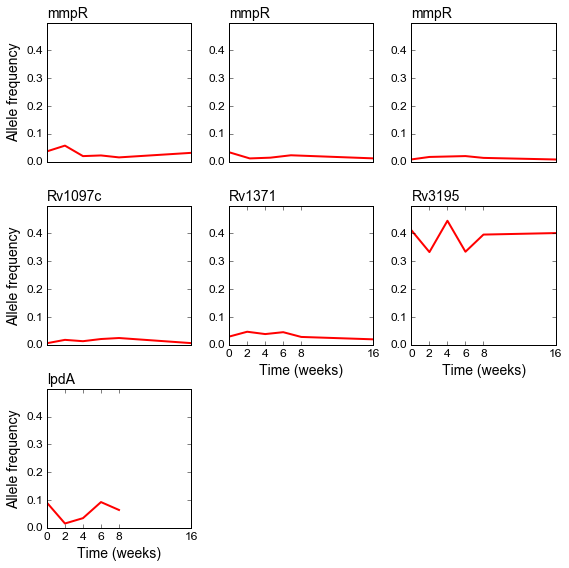

In [155]:
plt.figure(figsize=(8,8))

locus_id = ['mmpR', 'mmpR', 'mmpR', 'Rv1097c', 'Rv1371', 'Rv3195', 'lpdA']

for ind,locus in enumerate([779193,779215,779296,1225354,1543917,3564850,3689763]):
    plt.subplot(3,3,ind+1)
    plt.plot(ALL.TIME[(ALL.PATIENT_ID=='Patient12')&(ALL.LOCUS==locus)],
             ALL.FREQUENCY[(ALL.PATIENT_ID=='Patient12')&(ALL.LOCUS==locus)],
            'r-', lw=2)
    plt.title(locus_id[ind],loc='left',size=14)
    plt.ylim(0,.5)
    plt.yticks(np.arange(0,.5,.1),size=12)
    plt.xticks([],size=12)
    if ind>3: 
        plt.xticks([0,2,4,6,8,16],size=12)
        plt.xlabel('Time (weeks)', size=14)
    
    if ind in [0,3,6]:
        plt.ylabel('Allele frequency', size=14)
        
plt.tight_layout()

These are cleary minor but stable variants. Why are they not increasing in frequency? Does this argue that the bacteria in the sputum come from the constant leeching of bacteria in the different foci in the lung - as suggest by JoAnne Flynn? Or is this a minor but stable popultion within the microcosm of lung microbiota?

One of the dynamics that I should plot is that of gyrA mutations in Patient 10.

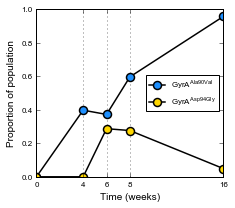

In [38]:
plt.figure('Patient10_gyrA', figsize=(3.35,3))
plt.plot([0]+list(ALL.TIME[(ALL.PATIENT_ID=='Patient10')&(ALL.LOCUS==7570)])+[16], 
         [0]+list(ALL.FREQUENCY[(ALL.PATIENT_ID=='Patient10')&(ALL.LOCUS==7570)])+[0.958], 
         label=r'$\mathregular{GyrA^{Ala90Val}}$',color='black',
         marker='o',mfc='dodgerblue',mew=1.5, ms=8, mec='black',lw=1.5)
plt.plot([0,4]+list(ALL.TIME[(ALL.PATIENT_ID=='Patient10')&(ALL.LOCUS==7582)])+[16], 
         [0,0]+list(ALL.FREQUENCY[(ALL.PATIENT_ID=='Patient10')&(ALL.LOCUS==7582)])+[0.0491], 
         label=r'$\mathregular{GyrA^{Asp94Gly}}$',color='black',
         marker='o',mfc='gold',mew=1.5, ms=8, mec='black',lw=1.5)
plt.xticks([0,4,6,8,16],[0,4,6,8,16],size=tick_size)
plt.yticks(size=tick_size)
plt.vlines([0,4,6,8,16],0,1,linestyles='dotted',lw=0.5)
plt.legend(loc=5, fontsize=text_size)
plt.xlabel('Time (weeks)', size=label_size)
plt.ylabel('Proportion of population', size=label_size)
#plt.title('Patient 10', size=18, loc='left')
plt.savefig('../reports/figures/3_P10_gyrA.pdf')
#plt.savefig('../reports/figures/3_P10_gyrA',dpi=300)

Might be worth to see if we can classify the trajectories of the v-SNPs as a way to describe population dynamics.

Let's first have a look at all the 58 recurrent v-SNPs:

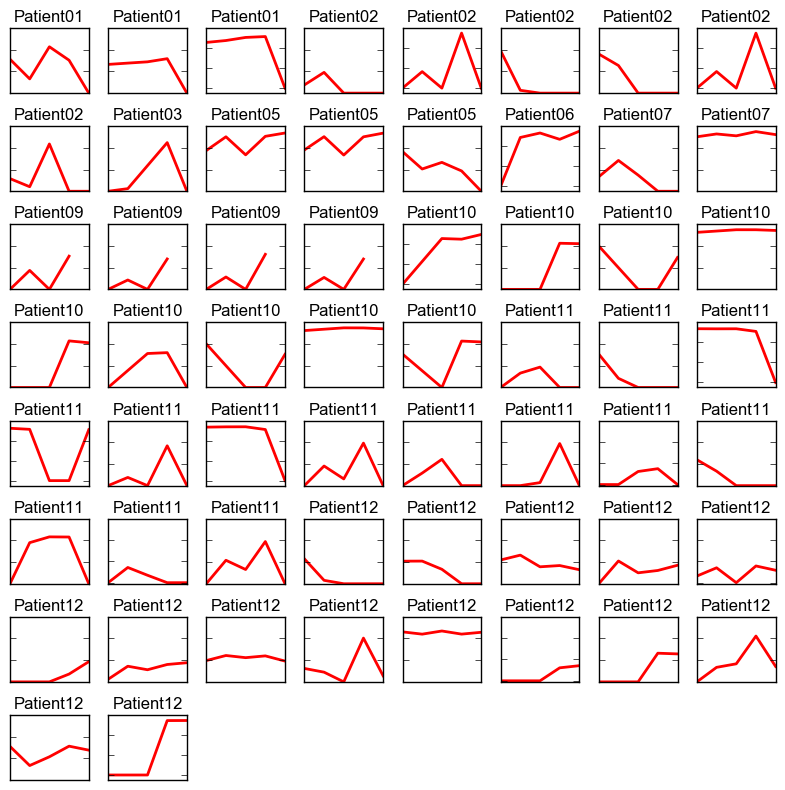

In [34]:
#RECURRENTS = np.unique(ALL.LOCUS[ALL.RECURRENT==1])
RECURRENTS = []
for x in sorted(RECURRENT_vSNP.keys()):
    RECURRENTS+=sorted(RECURRENT_vSNP[x])
    #Order recurrent v-SNPs first by PATIENT_ID and then by LOCUS

plt.figure('v-SNP trajectories', figsize=(8,8))
for ind,snp in enumerate(RECURRENTS):
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.subplot(8,8,ind+1)
    plt.plot(time, log_freqs, 'r-', lw=2)
    plt.xticks(np.arange(0,10,8),[])
    plt.yticks(np.arange(-5.5,2,2),[])
    plt.title('{}'.format(patient))
plt.tight_layout()

This is consistent with my expectations... Let's manually code the trajectory of these SNPs (0-ascending, 1-descending, 2-constant, 3-sporadic).

In [36]:
SNP_PATTERN = np.array([1,1,1,1,3,1,1,3,
               3,1,0,0,1,0,1,2,
               3,3,3,3,0,0,3,2,
               0,1,3,2,3,1,1,1,
               3,3,1,3,1,1,1,1,
               1,1,3,1,1,2,2,2,
               0,2,2,3,2,0,0,0,
               2,0])

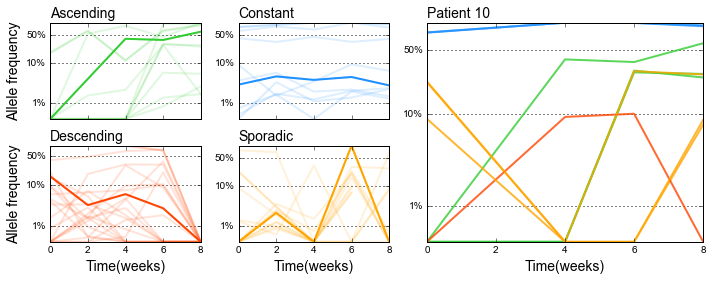

In [32]:
plt.figure(figsize=(10,4))

patient_of_interest = 'Patient10'

c=plt.subplot2grid((4,11), (0,0), rowspan=2, colspan=3)
pattern = 0
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='limegreen', lw=2, alpha=0.15)
    if snp==7570:
        plt.plot(time, log_freqs, '-', color='limegreen', lw=2)
plt.xticks(np.arange(0,10,2),[])
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'])
plt.title('Ascending', size=14, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=14)


c=plt.subplot2grid((4,11), (2,0), rowspan=2, colspan=3)
pattern = 1
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #e^-5.5 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='orangered', lw=2, alpha=0.15)
    if snp== 2892974:
        plt.plot(time, log_freqs, '-', color='orangered', lw=2)
plt.xticks(np.arange(0,10,2),[0,2,4,6,8])
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'])
plt.title('Descending', size=14, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=14)
plt.xlabel('Time(weeks)',size=14)


c=plt.subplot2grid((4,11), (0,3), rowspan=2, colspan=3)
pattern = 2
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='dodgerblue', lw=2, alpha=0.15)
    if snp== 1543917:
        plt.plot(time, log_freqs, '-', color='dodgerblue', lw=2)
plt.xticks(np.arange(0,10,2),[])
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'])
plt.title('Constant', size=14, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')


c=plt.subplot2grid((4,11), (2,3), rowspan=2, colspan=3)
pattern = 3
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='orange', lw=2, alpha=0.15)
    if snp== 4232644:
        plt.plot(time, log_freqs, '-', color='orange', lw=2)
plt.xticks(np.arange(0,10,2),[0,2,4,6,8])
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'])
plt.title('Sporadic', size=14, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.xlabel('Time(weeks)',size=14)

c=plt.subplot2grid((4,11), (0,6), rowspan=4, colspan=5)
for (snp,pattern) in zip(np.array(RECURRENTS),SNP_PATTERN):
    patcol = {0:'limegreen', 1:'orangered', 2:'dodgerblue', 3:'orange'}
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    _lf = log_freqs+[1]
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    if patient == patient_of_interest:
        plt.plot(time, log_freqs, '-', color=patcol[pattern], lw=2, alpha=0.8)
    
plt.xticks(np.arange(0,10,2),[0,2,4,6,8])
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'])
plt.title('{0}nt {1}'.format(patient_of_interest.split('nt')[0], patient_of_interest.split('nt')[1]), 
          size=14, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')

plt.xlabel('Time(weeks)',size=14)

plt.tight_layout()

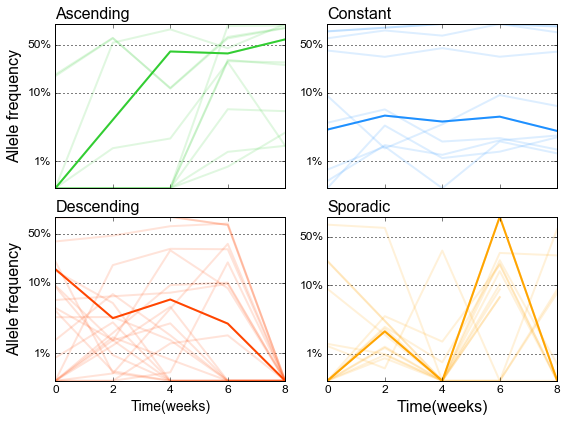

In [39]:
plt.figure(figsize=(8,6))

patient_of_interest = 'Patient10'

c=plt.subplot(2,2,1)
pattern = 0
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='limegreen', lw=2, alpha=0.15)
    if snp==7570:
        plt.plot(time, log_freqs, '-', color='limegreen', lw=2)
plt.xticks(np.arange(0,10,2),[], size=12)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=12)
plt.title('Ascending', size=16, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=16)


c=plt.subplot(2,2,3)
pattern = 1
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #e^-5.5 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='orangered', lw=2, alpha=0.15)
    if snp== 2892974:
        plt.plot(time, log_freqs, '-', color='orangered', lw=2)
plt.xticks(np.arange(0,10,2),[0,2,4,6,8], size=12)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=12)
plt.title('Descending', size=16, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=16)
plt.xlabel('Time(weeks)',size=14)


c=plt.subplot(2,2,2)
pattern = 2
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='dodgerblue', lw=2, alpha=0.15)
    if snp== 1543917:
        plt.plot(time, log_freqs, '-', color='dodgerblue', lw=2)
plt.xticks(np.arange(0,10,2),[], size=12)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=12)
plt.title('Constant', size=16, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')


c=plt.subplot(2,2,4)
pattern = 3
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='orange', lw=2, alpha=0.15)
    if snp== 4232644:
        plt.plot(time, log_freqs, '-', color='orange', lw=2)
plt.xticks(np.arange(0,10,2),[0,2,4,6,8], size=12)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=12)
plt.title('Sporadic', size=16, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.xlabel('Time(weeks)',size=16)

plt.tight_layout()

plt.savefig('../reports/figures/3_recurrence_pattern.pdf')
plt.savefig('../reports/figures/3_recurrence_pattern',dpi=300)

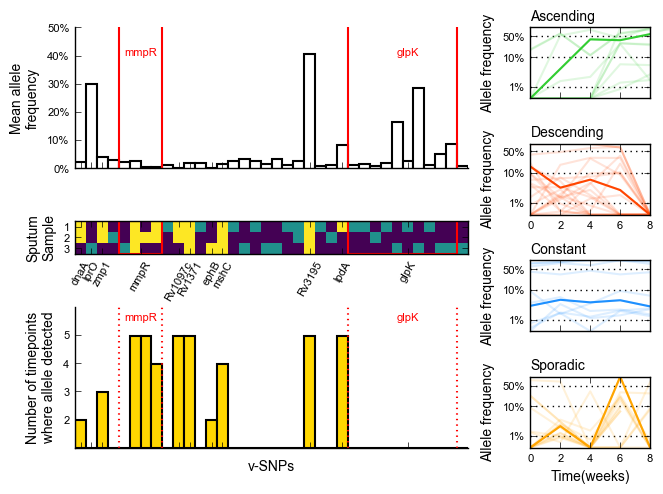

In [52]:
plt.figure(figsize=(6.7,5))

c=plt.subplot2grid((20,28), (0,0), rowspan=8, colspan=20)

plt.vlines(24.5,0,50,lw=1.5,colors='red')
plt.vlines(34.5,0,50,lw=1.5,colors='red')
plt.vlines(3.5,0,50,lw=1.5,colors='red')
plt.vlines(7.5,0,50,lw=1.5,colors='red')

plt.bar(np.arange(-0.5,35,1), 
        np.array(P12_T0_FREQ[[0,1,2]].sum(axis=1))/np.array(P12_T0_FREQ[[0,1,2]]>0).sum(axis=1),
        bottom=-.7, width=1, color='white',lw=1.5)
#plt.vlines(np.arange(0,35.5,1),
#           np.array(P12_T0_FREQ[[0,1,2]].sum(axis=1))/np.array(P12_T0_FREQ[[0,1,2]]>0).sum(axis=1)\
#           +np.std(P12_T0_FREQ[[0,1,2]], axis=1),
#           np.array(P12_T0_FREQ[[0,1,2]].sum(axis=1))/np.array(P12_T0_FREQ[[0,1,2]]>0).sum(axis=1)\
#           -np.std(P12_T0_FREQ[[0,1,2]], axis=1),
#          )

plt.ylabel('Mean allele\nfrequency', size=label_size)
plt.xlim(-.5,35.5)
plt.ylim(0,50)
plt.yticks(np.arange(0,60,10), 
           ['0%', '10%', '20%', '30%', '40%', '50%'],
           size=tick_size)
plt.xticks(np.arange(0,36,5),[])
plt.text(5.5,40,'mmpR',horizontalalignment='center',
         size=text_size,color='red')
plt.text(30,40,'glpK',horizontalalignment='center',
         size=text_size,color='red')
c.spines['right'].set_visible(False)
c.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
c.yaxis.set_ticks_position('left')
c.xaxis.set_ticks_position('bottom')

plt.xticks([0,1,2,5.5,9,10,12,13,21,24,30],
           rotation=60,size=tick_size)


plt.subplot2grid((20,28), (8,0), rowspan=4, colspan=20)
plt.imshow( (present+(present.T*recurrent).T).T, interpolation='none', aspect='equal', cmap='viridis')
plt.yticks([0,1,2],['1','2','3'],size=tick_size)
plt.ylabel('Sputum\nSample', size=label_size)
plt.vlines(24.5,-.50,2.5,lw=1.5,colors='red')
plt.vlines(34.5,-.50,2.5,lw=1.5,colors='red')
plt.vlines(3.5,-.50,2.5,lw=1.5,colors='red')
plt.vlines(7.5,-.50,2.5,lw=1.5,colors='red')

plt.hlines(-.50,24.5,34.5,lw=1.5,colors='red')
plt.hlines(2.5,24.5,34.5,lw=1.5,colors='red')
plt.hlines(-.50,3.5,7.5,lw=1.5,colors='red')
plt.hlines(2.5,3.5,7.5,lw=1.5,colors='red')

plt.xlim(-.5,35.5)

plt.xticks([0,1,2,5.5,9,10,12,13,21,24,30],
           ['dnaA','lprO','zmp1','mmpR','Rv1097c','Rv1371','ephB','mshC','Rv3195','lpdA','glpK'],
           rotation=60,size=tick_size)

d = plt.subplot2grid((20,28), (12,0), rowspan=8, colspan=20)
#count how many times each locus is present in the rest of the timepoints
COUNTINGS = Counter(list(ALL.LOCUS[(ALL.PATIENT_ID=='Patient12')&(ALL.TIME!=0)]))
PROPORTIONS = [COUNTINGS.get(x,0)*20 for x in P12_T0_FREQ.index]

plt.vlines(24.5,0,100,lw=1.5,colors='red',linestyles='dotted')
plt.vlines(34.5,0,100,lw=1.5,colors='red',linestyles='dotted')
plt.vlines(3.5,0,100,lw=1.5,colors='red',linestyles='dotted')
plt.vlines(7.5,0,100,lw=1.5,colors='red',linestyles='dotted')
plt.bar(np.arange(-0.5,35,1), 
        PROPORTIONS,
        bottom=-.7, width=1, color='gold',lw=1.5)
plt.ylabel('Number of timepoints\nwhere allele detected', size=label_size)
plt.xlim(-.5,35.5)
plt.ylim(0,100)
plt.yticks(np.arange(20,100,20), 
           ['2', '3', '4', '5'],
           size=tick_size)
plt.xticks(np.arange(0,36,5),[])
plt.text(5.5,90,'mmpR',horizontalalignment='center',
         size=text_size,color='red')
plt.text(30,90,'glpK',horizontalalignment='center',
         size=text_size,color='red')
d.spines['right'].set_visible(False)
d.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
d.yaxis.set_ticks_position('left')
d.xaxis.set_ticks_position('bottom')

plt.xticks([0,1,2,5.5,9,10,12,13,21,24,30],
           rotation=60,size=tick_size)

plt.xlabel('v-SNPs', size=label_size)

c=plt.subplot2grid((20,28), (0,20), rowspan=5, colspan=8)
pattern = 0
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='limegreen', lw=1.5, alpha=0.15)
    if snp==7570:
        plt.plot(time, log_freqs, '-', color='limegreen', lw=1.5)
plt.xticks(np.arange(0,10,2),[], size=tick_size)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=tick_size)
plt.title('Ascending', size=title_size, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=label_size)


c=plt.subplot2grid((20,28), (5,20), rowspan=5, colspan=8)
pattern = 1
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #e^-5.5 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='orangered', lw=1.5, alpha=0.15)
    if snp== 2892974:
        plt.plot(time, log_freqs, '-', color='orangered', lw=1.5)
plt.xticks(np.arange(0,10,2),[0,2,4,6,8], size=tick_size)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=tick_size)
plt.title('Descending', size=title_size, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=label_size)

c=plt.subplot2grid((20,28), (10,20), rowspan=5, colspan=8)
pattern = 2
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='dodgerblue', lw=1.5, alpha=0.15)
    if snp== 1543917:
        plt.plot(time, log_freqs, '-', color='dodgerblue', lw=1.5)
plt.xticks(np.arange(0,10,2),[], size=tick_size)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=tick_size)
plt.title('Constant', size=title_size, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=label_size)

c=plt.subplot2grid((20,28), (15,20), rowspan=5, colspan=8)
pattern = 3
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='orange', lw=1.5, alpha=0.15)
    if snp== 4232644:
        plt.plot(time, log_freqs, '-', color='orange', lw=1.5)
plt.xticks(np.arange(0,10,2),[0,2,4,6,8], size=tick_size)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=tick_size)
plt.title('Sporadic', size=title_size, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.xlabel('Time(weeks)',size=label_size)
plt.ylabel('Allele frequency',size=label_size)
plt.tight_layout()

#plt.savefig('../reports/figures/3_Combined.pdf')
#plt.savefig('../reports/figures/3_Combined',dpi=1200)

During the review process it came up that the above figure may not be sufficiently clear and that the lower left panel may be best represented as a presence/absence picture, like the middle panel. To do this I would have to first extract the relevant infomation from the PATIENT_DATA dictionary.

([<matplotlib.axis.YTick at 0x10c536da0>,
 <a list of 4 Text yticklabel objects>)

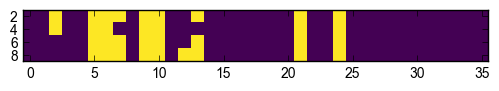

In [100]:
#Get patient index
PATIENT_INDEX = PATIENT_DATA['PATIENTS'].index('Patient12')

#Generate recipient array
P12_OTHER_TIMEPOINTS = np.zeros(shape=(36,4))

#Extract frequencies for a given allele at other times
for ind,x in enumerate(np.array(P12_T0_FREQ.index)):
    place = np.where(PATIENT_DATA['UNFIXED_ARRAYS'][PATIENT_INDEX][:,0]==x)[0]
    if place: P12_OTHER_TIMEPOINTS[ind]+=PATIENT_DATA['UNFIXED_ARRAYS'][PATIENT_INDEX][place[0],2:]

#Generate a presence absence matrix
GRID = np.array(P12_OTHER_TIMEPOINTS>0, dtype=int)
        
#Plot
plt.imshow(GRID.T+(GRID.T*recurrent), interpolation='none', cmap='viridis')
plt.yticks(range(4), ['2', '4', '6', '8'])

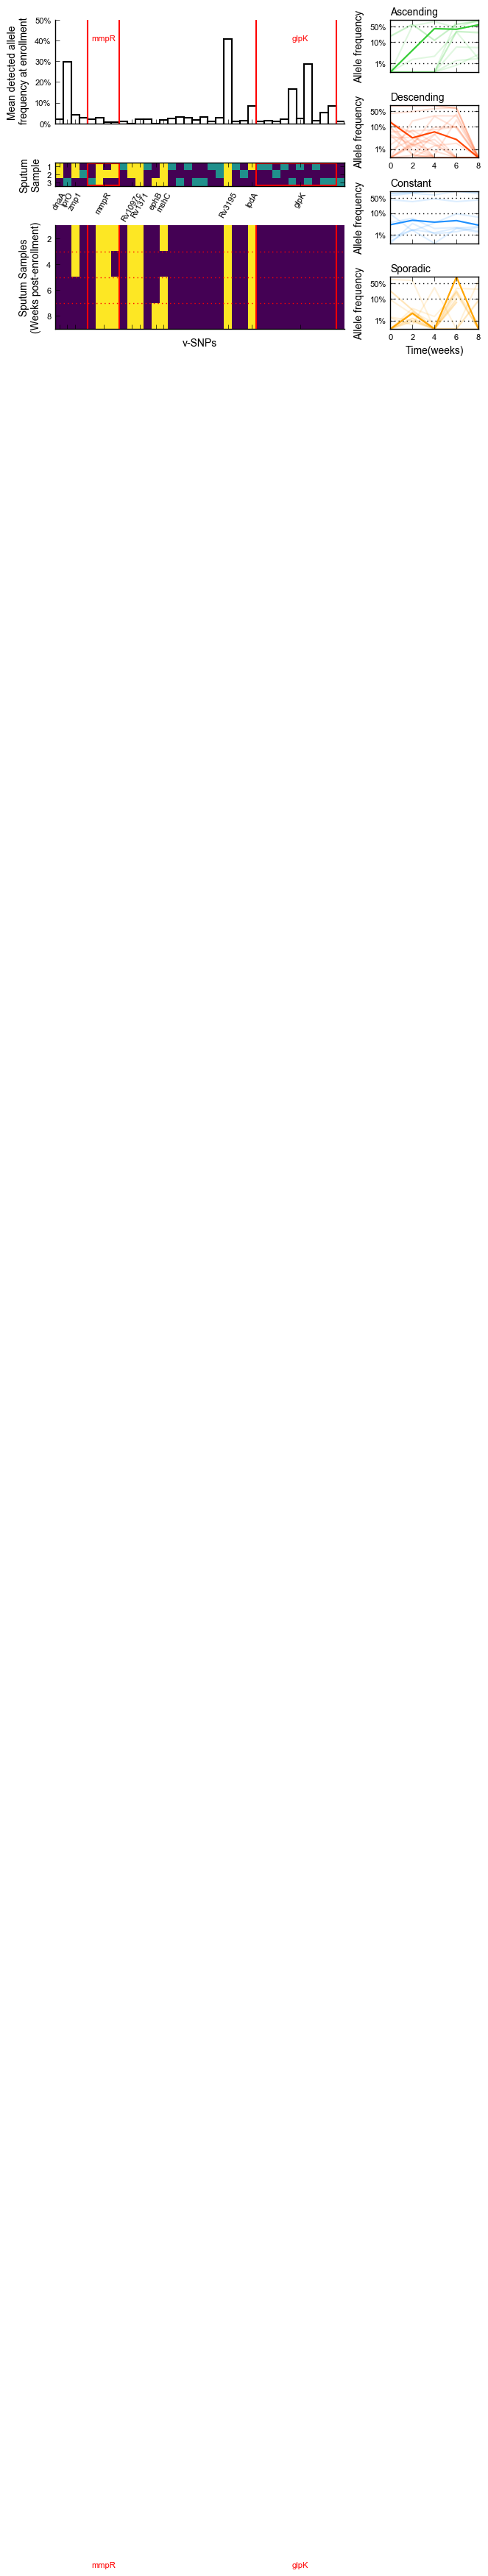

In [115]:
plt.figure(figsize=(6.7,5))

c=plt.subplot2grid((20,28), (0,0), rowspan=8, colspan=20)

plt.vlines(24.5,0,50,lw=1.5,colors='red')
plt.vlines(34.5,0,50,lw=1.5,colors='red')
plt.vlines(3.5,0,50,lw=1.5,colors='red')
plt.vlines(7.5,0,50,lw=1.5,colors='red')

plt.bar(np.arange(-0.5,35,1), 
        np.array(P12_T0_FREQ[[0,1,2]].sum(axis=1))/np.array(P12_T0_FREQ[[0,1,2]]>0).sum(axis=1),
        bottom=-.7, width=1, color='white',lw=1.5)
#plt.vlines(np.arange(0,35.5,1),
#           np.array(P12_T0_FREQ[[0,1,2]].sum(axis=1))/np.array(P12_T0_FREQ[[0,1,2]]>0).sum(axis=1)\
#           +np.std(P12_T0_FREQ[[0,1,2]], axis=1),
#           np.array(P12_T0_FREQ[[0,1,2]].sum(axis=1))/np.array(P12_T0_FREQ[[0,1,2]]>0).sum(axis=1)\
#           -np.std(P12_T0_FREQ[[0,1,2]], axis=1),
#          )

plt.ylabel('Mean detected allele\n frequency at enrollment', size=label_size)
plt.xlim(-.5,35.5)
plt.ylim(0,50)
plt.yticks(np.arange(0,60,10), 
           ['0%', '10%', '20%', '30%', '40%', '50%'],
           size=tick_size)
plt.xticks(np.arange(0,36,5),[])
plt.text(5.5,40,'mmpR',horizontalalignment='center',
         size=text_size,color='red')
plt.text(30,40,'glpK',horizontalalignment='center',
         size=text_size,color='red')
c.spines['right'].set_visible(False)
c.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
c.yaxis.set_ticks_position('left')
c.xaxis.set_ticks_position('bottom')

plt.xticks([0,1,2,5.5,9,10,12,13,21,24,30],
           rotation=60,size=tick_size)


plt.subplot2grid((20,28), (8,0), rowspan=4, colspan=20)
plt.imshow( (present+(present.T*recurrent).T).T, interpolation='none', aspect='equal', cmap='viridis')
plt.yticks([0,1,2],['1','2','3'],size=tick_size)
plt.ylabel('Sputum\nSample', size=label_size)
plt.vlines(24.5,-.50,2.5,lw=1.5,colors='red')
plt.vlines(34.5,-.50,2.5,lw=1.5,colors='red')
plt.vlines(3.5,-.50,2.5,lw=1.5,colors='red')
plt.vlines(7.5,-.50,2.5,lw=1.5,colors='red')

plt.hlines(-.50,24.5,34.5,lw=3,colors='red')
plt.hlines(2.5,24.5,34.5,lw=3,colors='red')
plt.hlines(-.50,3.5,7.5,lw=3,colors='red')
plt.hlines(2.5,3.5,7.5,lw=3,colors='red')

plt.xlim(-.5,35.5)
plt.xticks([0,1,2,5.5,9,10,12,13,21,24,30],
           ['dnaA','lprO','zmp1','mmpR','Rv1097c','Rv1371','ephB','mshC','Rv3195','lpdA','glpK'],
           rotation=60,size=tick_size)

d = plt.subplot2grid((20,28), (12,0), rowspan=8, colspan=20)
#count how many times each locus is present in the rest of the timepoints
plt.imshow(GRID.T+(GRID.T*recurrent), interpolation='none', aspect='auto', cmap='viridis')

plt.vlines(24.5,-0.5,3.5,lw=1.5, colors='red')
plt.vlines(34.5,-0.5,3.5,lw=1.5, colors='red')
plt.vlines(3.5,-0.5,3.5,lw=1.5, colors='red')
plt.vlines(7.5,-0.5,3.5,lw=1.5, colors='red')

plt.hlines(.50,-.5,35.5,lw=1,colors='red', linestyles='dotted')
plt.hlines(1.50,-.5,35.5,lw=1,colors='red', linestyles='dotted')
plt.hlines(2.5,-.5,35.5,lw=1,colors='red', linestyles='dotted')


plt.ylabel('Sputum Samples\n(Weeks post-enrollment)', size=label_size)
plt.xlim(-.5,35.5)
plt.yticks(range(4), ['2', '4', '6', '8'], size=tick_size)
plt.xticks(np.arange(0,36,5),[])
plt.text(5.5,90,'mmpR',horizontalalignment='center',
         size=text_size,color='red')
plt.text(30,90,'glpK',horizontalalignment='center',
         size=text_size,color='red')
d.spines['right'].set_visible(False)
d.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
d.yaxis.set_ticks_position('left')
d.xaxis.set_ticks_position('bottom')

plt.xticks([0,1,2,5.5,9,10,12,13,21,24,30],
           rotation=60,size=tick_size)

plt.xlabel('v-SNPs', size=label_size)

c=plt.subplot2grid((20,28), (0,20), rowspan=5, colspan=8)
pattern = 0
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='limegreen', lw=1.5, alpha=0.15)
    if snp==7570:
        plt.plot(time, log_freqs, '-', color='limegreen', lw=1.5)
plt.xticks(np.arange(0,10,2),[], size=tick_size)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=tick_size)
plt.title('Ascending', size=title_size, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=label_size)


c=plt.subplot2grid((20,28), (5,20), rowspan=5, colspan=8)
pattern = 1
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #e^-5.5 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='orangered', lw=1.5, alpha=0.15)
    if snp== 2892974:
        plt.plot(time, log_freqs, '-', color='orangered', lw=1.5)
plt.xticks(np.arange(0,10,2),[0,2,4,6,8], size=tick_size)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=tick_size)
plt.title('Descending', size=title_size, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=label_size)

c=plt.subplot2grid((20,28), (10,20), rowspan=5, colspan=8)
pattern = 2
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='dodgerblue', lw=1.5, alpha=0.15)
    if snp== 1543917:
        plt.plot(time, log_freqs, '-', color='dodgerblue', lw=1.5)
plt.xticks(np.arange(0,10,2),[], size=tick_size)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=tick_size)
plt.title('Constant', size=title_size, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.ylabel('Allele frequency',size=label_size)

c=plt.subplot2grid((20,28), (15,20), rowspan=5, colspan=8)
pattern = 3
for snp in np.array(RECURRENTS)[SNP_PATTERN==pattern]:
    time = [0,2,4,6,8]
    log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
    for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
        place = time.index(t)
        log_freqs[place] = f
    patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
    missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
    if missing:
        time.pop(missing-1)
        log_freqs.pop(missing-1)
    plt.plot(time, log_freqs, '-', color='orange', lw=1.5, alpha=0.15)
    if snp== 4232644:
        plt.plot(time, log_freqs, '-', color='orange', lw=1.5)
plt.xticks(np.arange(0,10,2),[0,2,4,6,8], size=tick_size)
plt.yticks(np.log([0.01,0.1,0.5]),['1%', '10%', '50%'], size=tick_size)
plt.title('Sporadic', size=title_size, loc='left')
plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
plt.xlabel('Time(weeks)',size=label_size)
plt.ylabel('Allele frequency',size=label_size)
plt.tight_layout()

plt.savefig('../reports/figures/3a_Combined.pdf')
plt.savefig('../reports/figures/3a_Combined',dpi=1200)

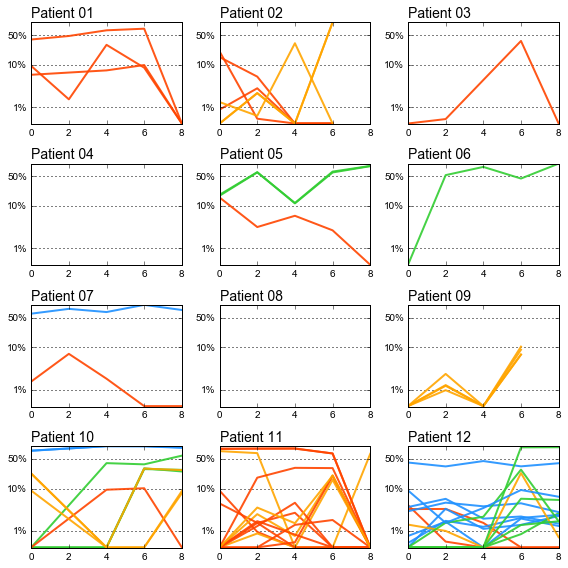

In [33]:
plt.figure(figsize=(8,8))

for patient_of_interest in PATIENT_DATA['PATIENTS']:
    ind = int(patient_of_interest[-2:])
    plt.subplot(4, 3, ind)
    for (snp,pattern) in zip(np.array(RECURRENTS),SNP_PATTERN):
        patcol = {0:'limegreen', 1:'orangered', 2:'dodgerblue', 3:'orange'}
        time = [0,2,4,6,8]
        log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
        for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
            place = time.index(t)
            log_freqs[place] = f
        patient = np.unique(ALL.PATIENT_ID[ALL.LOCUS==snp])[0] #get PATIENT_ID
        missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient)] #remove missing timepoints
        if missing:
            time.pop(missing-1)
            log_freqs.pop(missing-1)
        if patient == patient_of_interest and patient != 'Patient02':
            plt.plot(time, log_freqs, '-', color=patcol[pattern], lw=2, alpha=0.9)
        if patient == patient_of_interest and patient == 'Patient02':
            plt.plot(time[:-1], log_freqs[:-1], '-', color=patcol[pattern], lw=2, alpha=0.9)
    plt.xticks(np.arange(0,10,2),[0,2,4,6,8])
    plt.yticks(np.log([0.01,0.1,0.5,1.]),['1%', '10%', '50%',''])
    plt.ylim(np.log(0.004),np.log(1.004))
    plt.title('{0}nt {1}'.format(patient_of_interest.split('nt')[0], patient_of_interest.split('nt')[1]), 
              size=14, loc='left')
    plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
    plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
    plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')

    #plt.xlabel('Time(weeks)',size=14)

plt.tight_layout()

#plt.savefig('../reports/figures/3_supplement_trajectories.pdf')
#plt.savefig('../reports/figures/3_supplement_trajectories',dpi=300)

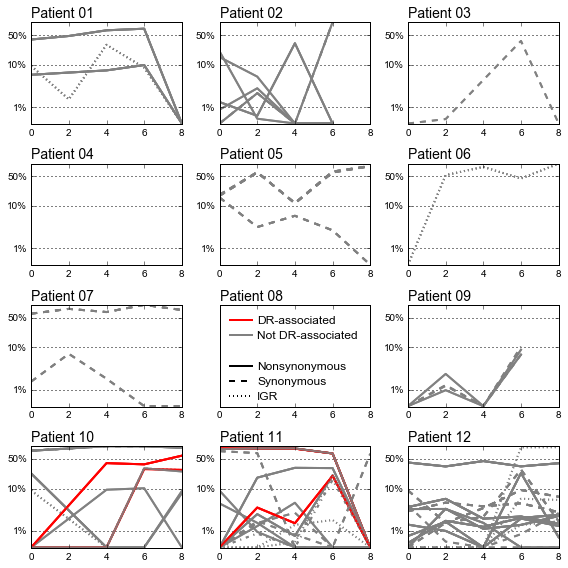

In [32]:
DR_set = ['Rv0006', 'Rv0026', 'Rv0402c', 'Rv0404', 'Rv0425c', 
          'Rv0658c', 'Rv1129c', 'Rv1181', 'Rv1319c', 'Rv1486c', 
          'Rv1895', 'Rv2764c', 'Rv2931', 'Rv2946c', 'Rv3795']

plt.figure(figsize=(8,8))

for patient_of_interest in PATIENT_DATA['PATIENTS']:
    ind = int(patient_of_interest[-2:])
    plt.subplot(4, 3, ind)
    for snp, snp_type, snp_gene in zip(ALL.LOCUS[(ALL.PATIENT_ID==patient_of_interest)&(ALL.RECURRENT==1)],
                                       ALL.SNP_TYPE[(ALL.PATIENT_ID==patient_of_interest)&(ALL.RECURRENT==1)],
                                       ALL.GENE[(ALL.PATIENT_ID==patient_of_interest)&(ALL.RECURRENT==1)]):
        pat = {'NSY':'-', 'SYN':'--', 'IGR':':', '-':'-.'}
        col = ['grey','red'][int(snp_gene in DR_set)]
        time = [0,2,4,6,8]
        log_freqs = [-5.5,]*5 #2^-8 roughly our limit of detection
        for t,f in zip(list(ALL.TIME[ALL.LOCUS==snp]), list(ALL.LOG_FREQ[ALL.LOCUS==snp])):
            place = time.index(t)
            log_freqs[place] = f
        missing = PATIENT_DATA['MISSING'][PATIENT_DATA['PATIENTS'].index(patient_of_interest)] #remove missing timepoints
        if missing:
            time.pop(missing-1)
            log_freqs.pop(missing-1)
        if patient_of_interest != 'Patient02':
            plt.plot(time, log_freqs, 
                     '{}'.format(pat[snp_type]), 
                     color=col, lw=2, alpha=0.9)
        if patient_of_interest == 'Patient02':
            plt.plot(time[:-1], log_freqs[:-1], 
                     '{}'.format(pat[snp_type]), 
                     color=col, lw=2, alpha=0.9)

    plt.title('{0}nt {1}'.format(patient_of_interest.split('nt')[0], patient_of_interest.split('nt')[1]), 
              size=14, loc='left')
    if patient_of_interest!='Patient08':
        plt.hlines(np.log(0.5), 0, 8, linestyles='dotted')
        plt.hlines(np.log(0.1), 0, 8, linestyles='dotted')
        plt.hlines(np.log(0.01), 0, 8, linestyles='dotted')
        plt.xticks(np.arange(0,10,2),[0,2,4,6,8])
        plt.yticks(np.log([0.01,0.1,0.5,1.]),['1%', '10%', '50%',''])
        plt.ylim(np.log(0.004),np.log(1.004))
    if patient_of_interest=='Patient08':
        plt.ylim(0,1)
        plt.yticks([0,1],[])
        plt.xlim(0,8)
        plt.xticks(np.arange(0,10,2),[0,2,4,6,8])
        plt.hlines(0.85,0.5,1.8,'red', lw=2)
        plt.text(2, 0.85, 'DR-associated', size=12, verticalalignment='center', horizontalalignment='left')
        plt.hlines(0.7,0.5,1.8,'grey', lw=2)
        plt.text(2, 0.7, 'Not DR-associated', size=12, verticalalignment='center', horizontalalignment='left')
        plt.hlines(0.4,0.5,1.8, lw=2)
        plt.text(2, 0.4, 'Nonsynonymous', size=12, verticalalignment='center', horizontalalignment='left')
        plt.hlines(0.25,0.5,1.8, linestyles='dashed', lw=2)
        plt.text(2, 0.25, 'Synonymous', size=12, verticalalignment='center', horizontalalignment='left')
        plt.hlines(0.10,0.5,1.8, linestyles='dotted', lw=2)
        plt.text(2, 0.10, 'IGR', size=12, verticalalignment='center', horizontalalignment='left')

    #plt.xlabel('Time(weeks)',size=14)

plt.tight_layout()

#plt.savefig('../reports/figures/3_supplement_trajectories_DR.pdf')
#plt.savefig('../reports/figures/3_supplement_trajectories_DR',dpi=300)

In [13]:
nohs = {}
click = 0

for patient in np.unique(ALL.PATIENT_ID):
    _c = Counter(ALL.TIME[(ALL.PATIENT_ID==patient)])
    _r = Counter(ALL.TIME[(ALL.PATIENT_ID==patient)&(ALL.RECURRENT==1)])
    for k,v in _c.items():                                                                                                        
        nohs[click] = {'PATIENT_ID': patient, 
                       'TIME': k, 'NOH': v, 
                       'NON_EFFICACIOUS': int(int(patient[-2:])>8),
                       'RECURRENT': _r[k]}
        click+=1           
                                  

click+=1;nohs[click] = {'PATIENT_ID': 'Patient01', 'TIME': 8, 'NOH': 0, 'NON_EFFICACIOUS': 0, 'RECURRENT': 0}
click+=1;nohs[click] = {'PATIENT_ID': 'Patient03', 'TIME': 0, 'NOH': 0, 'NON_EFFICACIOUS': 0, 'RECURRENT': 0}
click+=1;nohs[click] = {'PATIENT_ID': 'Patient03', 'TIME': 8, 'NOH': 0, 'NON_EFFICACIOUS': 0, 'RECURRENT': 0}
click+=1;nohs[click] = {'PATIENT_ID': 'Patient08', 'TIME': 0, 'NOH': 0, 'NON_EFFICACIOUS': 0, 'RECURRENT': 0}
click+=1;nohs[click] = {'PATIENT_ID': 'Patient08', 'TIME': 2, 'NOH': 0, 'NON_EFFICACIOUS': 0, 'RECURRENT': 0}

COUNTED_vSNPS = pd.DataFrame(nohs).T
COUNTED_vSNPS.sort('TIME', inplace=True)

COUNTED_vSNPS['NON_EFFICACIOUS'] = pd.to_numeric(COUNTED_vSNPS['NON_EFFICACIOUS'])
COUNTED_vSNPS['NOH'] = pd.to_numeric(COUNTED_vSNPS['NOH'])



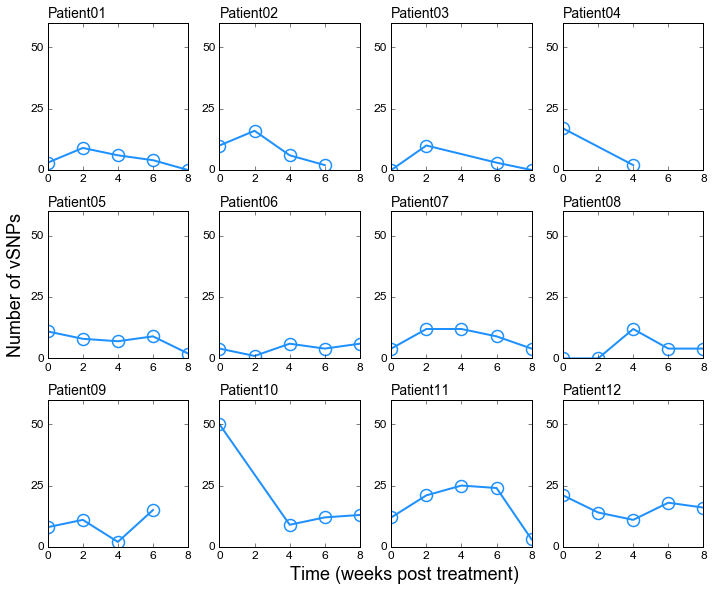

In [65]:
plt.figure(figsize=(10,8))
for ind,patient in enumerate(np.unique(ALL.PATIENT_ID)):
    plt.subplot(3,4,ind+1)
    plt.plot(COUNTED_vSNPS.TIME[COUNTED_vSNPS.PATIENT_ID==patient], 
             COUNTED_vSNPS.NOH[COUNTED_vSNPS.PATIENT_ID==patient], 
             '-', color='dodgerblue', marker='o', ms=12, mew=1.5,
             mfc='none', mec='dodgerblue', lw=2)
    plt.ylim(0,60)
    plt.xticks([0,2,4,6,8],size=12)
    plt.yticks(np.arange(0,60,25),size=12)
    plt.title(patient, size=14, loc='left')
    if ind==4:
        plt.ylabel('Number of vSNPs', size=18)

plt.tight_layout()
plt.subplot(3,4,10)
plt.xlabel('Time (weeks post treatment)', size=18, horizontalalignment='left')

In [57]:
model = sm.Logit.from_formula('NON_EFFICACIOUS ~ NOH', data=COUNTED_vSNPS)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.437772
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        NON_EFFICACIOUS   No. Observations:                   53
Model:                          Logit   Df Residuals:                       51
Method:                           MLE   Df Model:                            1
Date:                Tue, 25 Oct 2016   Pseudo R-squ.:                  0.3168
Time:                        15:47:01   Log-Likelihood:                -23.202
converged:                       True   LL-Null:                       -33.962
                                        LLR p-value:                 3.503e-06
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.1409      0.832     -3.774      0.000        -4.772    -1.510
NOH            0.2548      0.

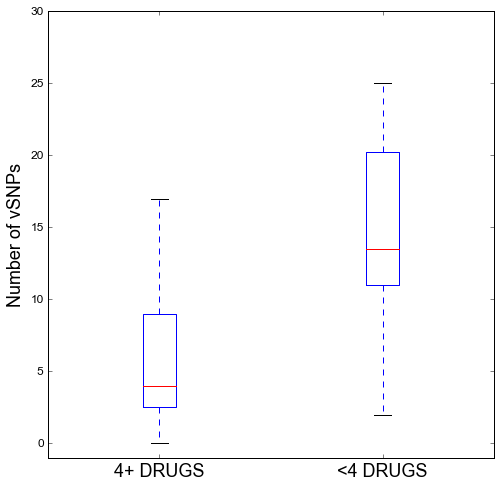

In [60]:
plt.figure(figsize=(8,8))
plt.boxplot([COUNTED_vSNPS.NOH[COUNTED_vSNPS.NON_EFFICACIOUS==0],
             COUNTED_vSNPS.NOH[COUNTED_vSNPS.NON_EFFICACIOUS==1]])
plt.xticks([1,2],['4+ DRUGS', '<4 DRUGS'], size=18)
plt.yticks(size=12)
plt.ylim(-1,30)
plt.ylabel('Number of vSNPs', size=18)

In [62]:
print(ss.levene(COUNTED_vSNPS.NOH[COUNTED_vSNPS.NON_EFFICACIOUS==0],
                COUNTED_vSNPS.NOH[COUNTED_vSNPS.NON_EFFICACIOUS==1]))

print(ss.ttest_ind(COUNTED_vSNPS.NOH[COUNTED_vSNPS.NON_EFFICACIOUS==0],
                   COUNTED_vSNPS.NOH[COUNTED_vSNPS.NON_EFFICACIOUS==1], 
                   equal_var=False))

LeveneResult(statistic=3.8611547194763389, pvalue=0.054874761701641274)
Ttest_indResult(statistic=-3.7748608659552407, pvalue=0.0011645681023071143)


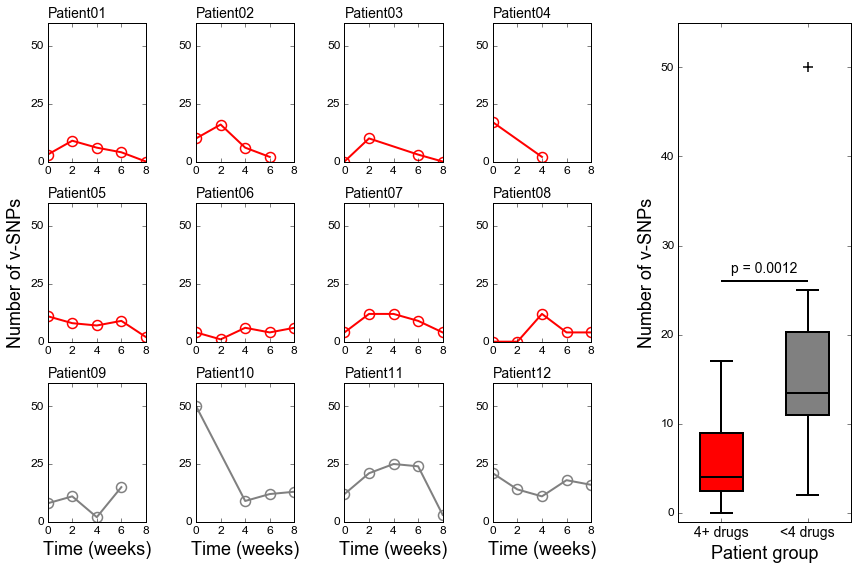

In [15]:
plt.figure(figsize=(12,8))
for (patient,loc,col) in zip(np.unique(ALL.PATIENT_ID), 
                             [(0,0),(0,4),(0,8),(0,12),(2,0),(2,4),(2,8),(2,12),(4,0),(4,4),(4,8),(4,12)], 
                             ['red',]*8+['grey',]*4):
    plt.subplot2grid((6,23),loc,colspan=4,rowspan=2)
    plt.plot(COUNTED_vSNPS.TIME[COUNTED_vSNPS.PATIENT_ID==patient], 
             COUNTED_vSNPS.NOH[COUNTED_vSNPS.PATIENT_ID==patient], 
             '-', color=col, marker='o', ms=10, mew=1.5,
             mfc='none', mec=col, lw=2)
    plt.ylim(0,60)
    plt.xticks([0,2,4,6,8],size=12)
    plt.yticks(np.arange(0,60,25),size=12)
    plt.title(patient, size=14, loc='left')
    if patient=='Patient05':
        plt.ylabel('Number of v-SNPs', size=18)
    if loc[0]==4:
        plt.xlabel('Time (weeks)', size=18)

plt.subplot2grid((6,23),(0,17),colspan=6,rowspan=6)
bp = plt.boxplot([COUNTED_vSNPS.NOH[COUNTED_vSNPS.NON_EFFICACIOUS==0],
                  COUNTED_vSNPS.NOH[COUNTED_vSNPS.NON_EFFICACIOUS==1]], 
                 patch_artist=True, widths=.5)

for box in bp['boxes']:
    box.set(color='black',lw=2)

for whisker in bp['whiskers']:
    whisker.set(color='black', linestyle='solid',lw=2)

for median in bp['medians']:
    median.set(color='black', lw=2)

for cap in bp['caps']:
    cap.set(color='black',lw=2)

for flier in bp['fliers']:
    flier.set(marker='+', color='black', mew=1.5, mfc='white', ms=10)

bp['boxes'][0].set(facecolor = 'red')
bp['boxes'][1].set(facecolor = 'grey')
    
plt.xticks([1,2],['4+ drugs', '<4 drugs'], size=14)
plt.ylabel('Number of v-SNPs', size=18)
plt.xlabel('Patient group', size=18)
plt.yticks(size=12)
plt.ylim(-1,55)

plt.hlines(26,1,2,lw=2)
plt.text(1.5, 27,'p = 0.0012', size=14,horizontalalignment='center')

plt.tight_layout()

#plt.savefig('../reports/figures/3_supplement_noh.pdf')
#plt.savefig('../reports/figures/3_supplement_noh',dpi=300)

In [117]:
COUNTED_vSNPS.NOH[(COUNTED_vSNPS.NON_EFFICACIOUS==0)].describe()

count    35.000000
mean      5.914286
std       4.591369
min       0.000000
25%       2.500000
50%       4.000000
75%       9.000000
max      17.000000
Name: NOH, dtype: float64

In [118]:
COUNTED_vSNPS.NOH[(COUNTED_vSNPS.NON_EFFICACIOUS==1)].describe()

count    18.000000
mean     15.833333
std      10.650877
min       2.000000
25%      11.000000
50%      13.500000
75%      20.250000
max      50.000000
Name: NOH, dtype: float64

LeveneResult(statistic=0.4937373147377177, pvalue=0.48580578523372608)
MannwhitneyuResult(statistic=192.5, pvalue=0.049876825762795021)


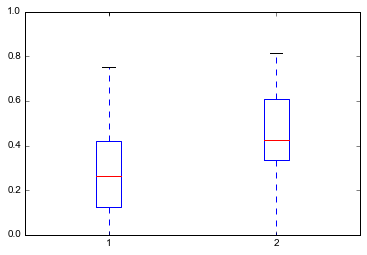

In [113]:
plt.figure()

COUNTED_vSNPS['RECRATIO'] = [np.divide(x,y) for (x,y) in zip(COUNTED_vSNPS.RECURRENT,COUNTED_vSNPS.NOH)]

plt.boxplot([list(COUNTED_vSNPS.RECRATIO[(COUNTED_vSNPS.NON_EFFICACIOUS==0)&(COUNTED_vSNPS.RECRATIO.notnull())]),
             list(COUNTED_vSNPS.RECRATIO[(COUNTED_vSNPS.NON_EFFICACIOUS==1)&(COUNTED_vSNPS.RECRATIO.notnull())])])

print(ss.levene(list(COUNTED_vSNPS.RECRATIO[(COUNTED_vSNPS.NON_EFFICACIOUS==0)&(COUNTED_vSNPS.RECRATIO.notnull())]),
             list(COUNTED_vSNPS.RECRATIO[(COUNTED_vSNPS.NON_EFFICACIOUS==1)&(COUNTED_vSNPS.RECRATIO.notnull())])))

print(ss.mannwhitneyu(list(COUNTED_vSNPS.RECRATIO[(COUNTED_vSNPS.NON_EFFICACIOUS==0)&(COUNTED_vSNPS.RECRATIO.notnull())]),
             list(COUNTED_vSNPS.RECRATIO[(COUNTED_vSNPS.NON_EFFICACIOUS==1)&(COUNTED_vSNPS.RECRATIO.notnull())])))

In [115]:
COUNTED_vSNPS.RECRATIO[(COUNTED_vSNPS.NON_EFFICACIOUS==0)&(COUNTED_vSNPS.RECRATIO.notnull())].describe()

count    30.000000
mean      0.338191
std       0.318951
min       0.000000
25%       0.125000
50%       0.261364
75%       0.421429
max       1.000000
Name: RECRATIO, dtype: float64

In [116]:
COUNTED_vSNPS.RECRATIO[(COUNTED_vSNPS.NON_EFFICACIOUS==1)&(COUNTED_vSNPS.RECRATIO.notnull())].describe()

count    18.000000
mean      0.439139
std       0.248849
min       0.000000
25%       0.333333
50%       0.422619
75%       0.607372
max       0.812500
Name: RECRATIO, dtype: float64

## Derive time-point DataFrames

Look at big-picture temporal dynamics of the MTBC populations within patients.

In [7]:
CCDC5079_genome = 4414325

TIMEPOINT_DATA = {'PATIENT_ID': [], 
                  'TIME': [], 
                  'MEAN_FREQUENCY': [], 
                  'LOG_MEAN_FREQUENCY': [],
                  'MEDIAN_FREQUENCY': [],
                  'VARIANCE_FREQUENCY': [],
                  'vSNP_COUNT': [],
                  'HETEROZYGOSITY': [],
                  'DEPTH': [],
                  'MEAN_SYN_FREQUENCY': [],
                  'MEAN_NSY_FREQUENCY': [],
                  'pNS_fSNP': [],
                  'NEUTRAL_pNS_fSNP': [],
                  'pNS_vSNP': [],
                  'NEUTRAL_pNS_vSNP': [],
                  'NON_EFFICACIOUS': []
                  }

for _patient in PATIENT_DATA['PATIENTS']:
    _timepoints = list(set(ALL.TIME[ALL.PATIENT_ID==_patient]))
    for _timepoint in _timepoints:
        _frequencies = list(ALL.FREQUENCY[(ALL.TIME==_timepoint)&(ALL.PATIENT_ID==_patient)])
        _mean_frequency = np.mean(_frequencies)
        _median_frequency = np.median(_frequencies)
        _variance = np.var(_frequencies)
        _heterozygosity = serf.heterozygosity(np.array(_frequencies),
                                              CCDC5079_genome)
        _effective = int(_patient in ['Patient09', 'Patient10', 'Patient11', 'Patient12'])
        _NSY_mean = np.mean(ALL.FREQUENCY[(ALL.TIME==_timepoint)&(ALL.PATIENT_ID==_patient)&(ALL.SNP_TYPE=='NSY')])
        _SYN_mean = np.mean(ALL.FREQUENCY[(ALL.TIME==_timepoint)&(ALL.PATIENT_ID==_patient)&(ALL.SNP_TYPE=='SYN')])

        TIMEPOINT_DATA['PATIENT_ID'].append(_patient)
        TIMEPOINT_DATA['TIME'].append(_timepoint)
        TIMEPOINT_DATA['MEAN_FREQUENCY'].append(_mean_frequency)
        TIMEPOINT_DATA['LOG_MEAN_FREQUENCY'].append(np.log(_mean_frequency))
        TIMEPOINT_DATA['MEDIAN_FREQUENCY'].append(_median_frequency)
        TIMEPOINT_DATA['VARIANCE_FREQUENCY'].append(_variance)
        TIMEPOINT_DATA['MEAN_SYN_FREQUENCY'].append(_SYN_mean)
        TIMEPOINT_DATA['MEAN_NSY_FREQUENCY'].append(_NSY_mean)
        TIMEPOINT_DATA['vSNP_COUNT'].append(len(_frequencies))
        TIMEPOINT_DATA['HETEROZYGOSITY'].append(_heterozygosity)
        TIMEPOINT_DATA['DEPTH'].append(PATIENT_DATA['DEPTH'][_patient][_timepoint])
        TIMEPOINT_DATA['NON_EFFICACIOUS'].append(_effective)
        TIMEPOINT_DATA['pNS_fSNP'].append(_effective)
        TIMEPOINT_DATA['NEUTRAL_pNS_fSNP'].append(_effective)
        TIMEPOINT_DATA['pNS_vSNP'].append(_effective)
        TIMEPOINT_DATA['NEUTRAL_pNS_vSNP'].append(_effective)
        
TIMEPOINT_DF = pd.DataFrame(TIMEPOINT_DATA)

In [4]:
TIMEPOINT_DF = pd.read_csv('../data/processed/CLINICAL_info.csv', index_col=0)

### Correlation between time to positivity and treatment

Rough reality check to see weather or not the number of drugs used influence the rate of bacterial clearance.

In [5]:
model = sm.MixedLM.from_formula('TIME_TO_POSITIVITY_MGIT ~ TIME * NON_EFFICACIOUS', 
                                data=TIMEPOINT_DF, 
                                groups=TIMEPOINT_DF.PATIENT_ID)
result = model.fit()
print(result.summary())

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: TIME_TO_POSITIVITY_MGIT
No. Observations: 52      Method:             REML                   
No. Groups:       12      Scale:              15.2595                
Min. group size:  2       Likelihood:         -150.9715              
Max. group size:  5       Converged:          Yes                    
Mean group size:  4.3                                                
----------------------------------------------------------------------
                       Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept              12.736     1.882   6.766  0.000   9.046  16.425
TIME                    1.148     0.247   4.649  0.000   0.664   1.633
NON_EFFICACIOUS        -0.198     3.271  -0.061  0.952  -6.609   6.213
TIME:NON_EFFICACIOUS   -0.826     0.417  -1.983  0.047  -1.643  -0.010
Intercept RE           18.426

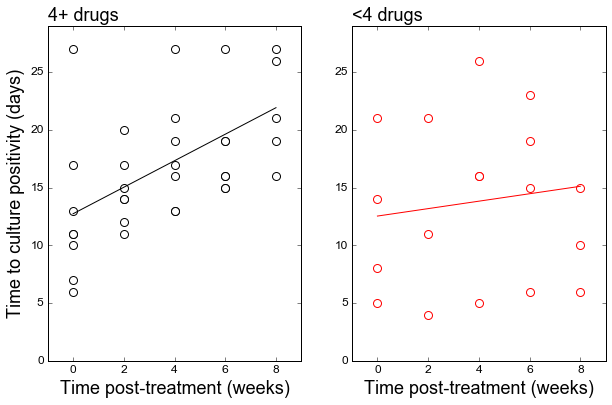

In [7]:
i = result.params[0]
ni = result.params[0]+result.params[2]           

s = result.params[1]
sn = result.params[1]+result.params[3]

plt.figure('timetopos',figsize=(10,6))

plt.subplot(121)
plt.plot(TIMEPOINT_DF.TIME[TIMEPOINT_DF.NON_EFFICACIOUS==0], 
         TIMEPOINT_DF.TIME_TO_POSITIVITY_MGIT[TIMEPOINT_DF.NON_EFFICACIOUS==0], 
         'o', mec='black',  mfc='white', mew=1., ms=8)
plt.xlim(-1,9)
plt.ylim(0,29)
plt.yticks(size=12)
plt.xticks(size=12)
plt.plot(np.arange(0,9), np.arange(0,9)*s+i, 'k-')
plt.title('4+ drugs', size=18, loc='left')
plt.xlabel('Time post-treatment (weeks)', size=18)
plt.ylabel('Time to culture positivity (days)', size=18)

plt.subplot(122)
plt.plot(TIMEPOINT_DF.TIME[TIMEPOINT_DF.NON_EFFICACIOUS==1], 
         TIMEPOINT_DF.TIME_TO_POSITIVITY_MGIT[TIMEPOINT_DF.NON_EFFICACIOUS==1], 
         'o', mec='red',  mfc='white', mew=1., ms=8)
plt.xlim(-1,9)
plt.ylim(0,29)
plt.yticks(size=12)
plt.xticks(size=12)
plt.plot(np.arange(0,9), np.arange(0,9)*sn+ni, 'r-')
plt.title('<4 drugs', size=18, loc='left')
plt.xlabel('Time post-treatment (weeks)', size=18)

#plt.savefig('../reports/figures/3_supplement_ttp.pdf')
#plt.savefig('../reports/figures/3_supplement_ttp',dpi=300)

### Correlation between sequencing depth and vSNP_count

Another reality check to see weather or not the number of detected vSNPs is proportional to sequencing depth.

In [14]:
TIMEPOINT_DF['OUTLIER'] = [int(x==50) for x in TIMEPOINT_DF.vSNP_COUNT]

(0, 2500)

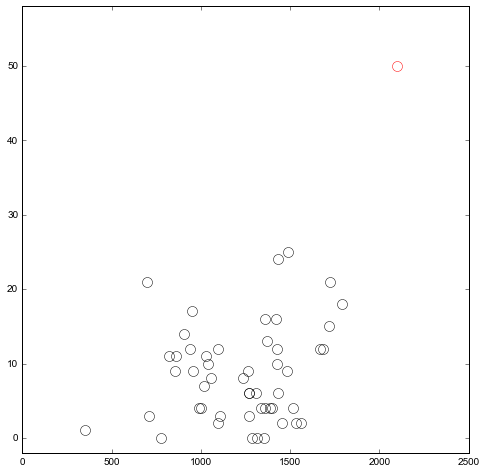

In [18]:
plt.figure(figsize=(8,8))

plt.plot(TIMEPOINT_DF.DEPTH[TIMEPOINT_DF.OUTLIER==0], 
         TIMEPOINT_DF.vSNP_COUNT[TIMEPOINT_DF.OUTLIER==0],  
         'o', mec='black', mfc='none', ms=10)

plt.plot(TIMEPOINT_DF.DEPTH[TIMEPOINT_DF.OUTLIER==1], 
         TIMEPOINT_DF.vSNP_COUNT[TIMEPOINT_DF.OUTLIER==1],  
         'o', mec='red', mfc='none', ms=10)

plt.ylim(-2,58)
plt.xlim(0,2500)

In [19]:
model = sm.MixedLM.from_formula('vSNP_COUNT ~ DEPTH', 
                                data=TIMEPOINT_DF, 
                                groups=TIMEPOINT_DF['PATIENT_ID'])
result = model.fit()
print(result.summary())

model = sm.MixedLM.from_formula('vSNP_COUNT ~ DEPTH', 
                                data=TIMEPOINT_DF[TIMEPOINT_DF.OUTLIER!=1], 
                                groups=TIMEPOINT_DF['PATIENT_ID'][TIMEPOINT_DF.OUTLIER!=1])
result_noutlier = model.fit()
print(result_noutlier.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: vSNP_COUNT
No. Observations: 52      Method:             REML      
No. Groups:       12      Scale:              49.0959   
Min. group size:  2       Likelihood:         -182.7000 
Max. group size:  5       Converged:          Yes       
Mean group size:  4.3                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.939    4.260 -0.220 0.826 -9.288  7.411
DEPTH          0.008    0.003  2.612 0.009  0.002  0.015
Intercept RE  15.640    2.000                           

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: vSNP_COUNT
No. Observations: 51      Method:             REML      
No. Groups:       12      Scale:              26.6543   
Min. group size:  2       Likelihood:         -165

In [40]:
model = sm.MixedLM.from_formula('vSNP_COUNT ~ TIME_TO_POSITIVITY_MGIT', 
                                data=TIMEPOINT_DF, 
                                groups=TIMEPOINT_DF['PATIENT_ID'])
ttp_result = model.fit()
print(ttp_result.summary())

model = sm.MixedLM.from_formula('vSNP_COUNT ~ TIME_TO_POSITIVITY_MGIT', 
                                data=TIMEPOINT_DF[TIMEPOINT_DF.OUTLIER!=1], 
                                groups=TIMEPOINT_DF['PATIENT_ID'][TIMEPOINT_DF.OUTLIER!=1])
ttp_result_noutlier = model.fit()
print(ttp_result_noutlier.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    vSNP_COUNT
No. Observations:     52         Method:                REML      
No. Groups:           12         Scale:                 50.4445   
Min. group size:      2          Likelihood:            -179.2781 
Max. group size:      5          Converged:             Yes       
Mean group size:      4.3                                         
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               16.619    3.406  4.880 0.000  9.943 23.294
TIME_TO_POSITIVITY_MGIT -0.456    0.194 -2.351 0.019 -0.836 -0.076
Intercept RE            16.126    2.028                           

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    vSNP_COUNT
No. Observations:     51

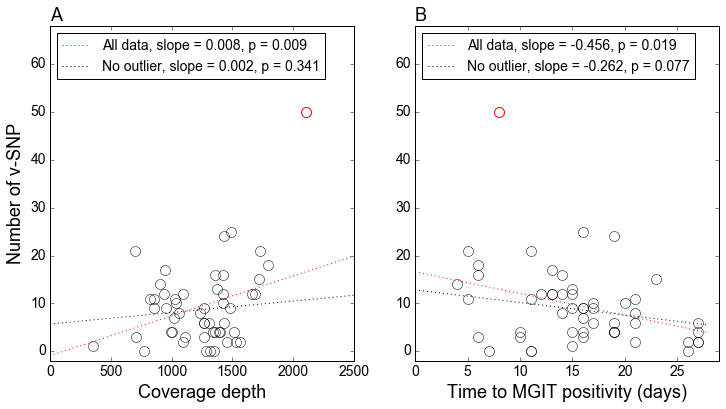

In [46]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title('A', size=18, loc='left')
plt.plot(np.arange(2500), 
         np.arange(2500)*result.params[1]+result.params[0], 
         'r:', 
         label='All data, slope = {0:0.3f}, p = {1:0.3f}'.format(result.params[1], 
                                                     result.pvalues[1]))
plt.plot(np.arange(2500), 
         np.arange(2500)*result_noutlier.params[1]+result_noutlier.params[0], 
         'k:', 
         label='No outlier, slope = {0:0.3f}, p = {1:0.3f}'.format(result_noutlier.params[1], 
                                                             result_noutlier.pvalues[1]))

plt.legend(fontsize=14, loc=2)

plt.plot(TIMEPOINT_DF.DEPTH[TIMEPOINT_DF.OUTLIER==0], 
         TIMEPOINT_DF.vSNP_COUNT[TIMEPOINT_DF.OUTLIER==0],  
         'o', mec='black', mfc='none', ms=10)

plt.plot(TIMEPOINT_DF.DEPTH[TIMEPOINT_DF.OUTLIER==1], 
         TIMEPOINT_DF.vSNP_COUNT[TIMEPOINT_DF.OUTLIER==1],  
         'o', mec='red', mfc='none', ms=10, mew=1.)



plt.ylim(-2,68)
plt.yticks(size=14)
plt.ylabel('Number of v-SNP', size=18)
plt.xlim(0,2500)
plt.xticks(size=14)
plt.xlabel('Coverage depth', size=18)

plt.subplot(122)
plt.title('B', size=18, loc='left')
plt.plot(np.arange(29), 
         np.arange(29)*ttp_result.params[1]+ttp_result.params[0], 
         'r:', 
         label='All data, slope = {0:0.3f}, p = {1:0.3f}'.format(ttp_result.params[1], 
                                                     ttp_result.pvalues[1]))
plt.plot(np.arange(29), 
         np.arange(29)*ttp_result_noutlier.params[1]+ttp_result_noutlier.params[0], 
         'k:', 
         label='No outlier, slope = {0:0.3f}, p = {1:0.3f}'.format(ttp_result_noutlier.params[1], 
                                                             ttp_result_noutlier.pvalues[1]))
plt.legend(fontsize=14, loc=2)

plt.plot(TIMEPOINT_DF.TIME_TO_POSITIVITY_MGIT[TIMEPOINT_DF.OUTLIER==0], 
         TIMEPOINT_DF.vSNP_COUNT[TIMEPOINT_DF.OUTLIER==0],  
         'o', mec='black', mfc='none', ms=10)

plt.plot(TIMEPOINT_DF.TIME_TO_POSITIVITY_MGIT[TIMEPOINT_DF.OUTLIER==1], 
         TIMEPOINT_DF.vSNP_COUNT[TIMEPOINT_DF.OUTLIER==1],  
         'o', mec='red', mfc='none', ms=10, mew=1.)

plt.ylim(-2,68)
plt.yticks(size=14)
plt.xlim(0,29)
plt.xticks(size=14)
plt.xlabel('Time to MGIT positivity (days)', size=18)


#plt.savefig('../reports/figures/3_supplement_depthnoh.pdf')
#plt.savefig('../reports/figures/3_supplement_depthnoh',dpi=300)

Looks like there is a slight correlation between depth and number of vSNPs detected. The slope suggests that on average we observe 1 additional SNP per 100-fold coverage increase. Nonetheless, coverage explains only 15% of the variance in the sample. Therefore, coverage does slightly increase the number of detected vSNPs but this effect is minor.

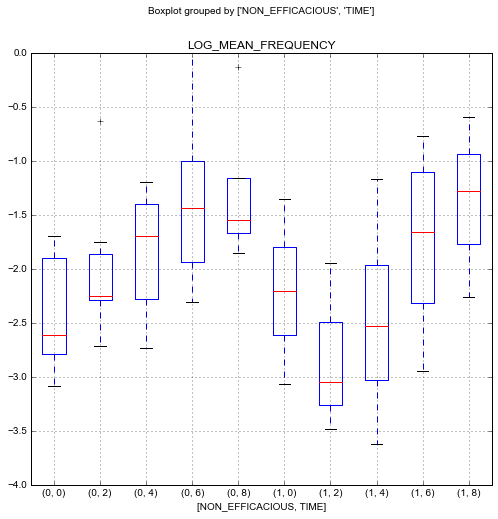

In [17]:
plt.figure(figsize=(8,8))
TIMEPOINT_DF.boxplot('LOG_MEAN_FREQUENCY', by=['NON_EFFICACIOUS', 'TIME'], figsize=(8,8))

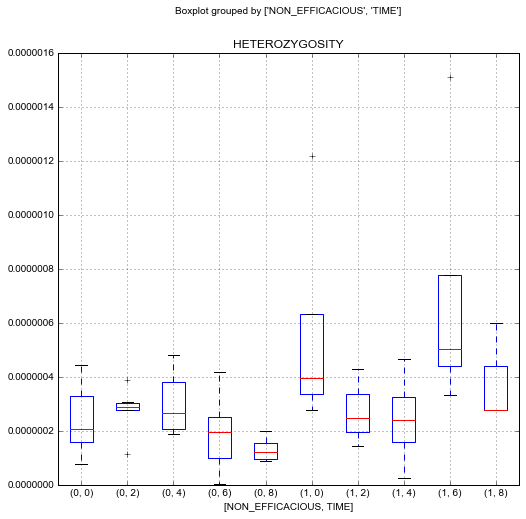

In [16]:
TIMEPOINT_DF.boxplot('HETEROZYGOSITY', by=['NON_EFFICACIOUS', 'TIME'], figsize=(8,8))

## Simple SFS

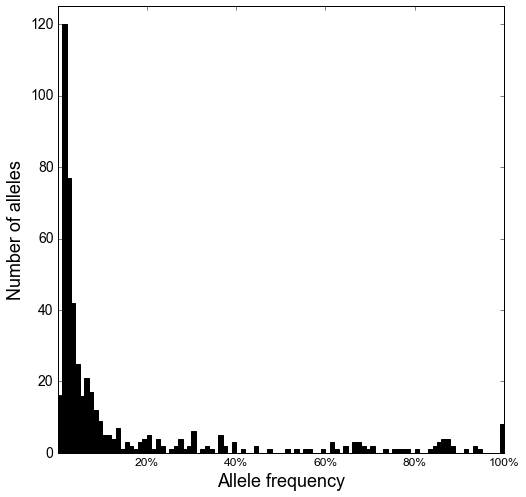

In [5]:
plt.figure('SFS', figsize=(8,8))
plt.hist(np.array(ALL.FREQUENCY[(ALL.TIME<12)]), bins=np.arange(0,1.01,0.01), 
         label=r'$M.tuberculosis$ - TB patients', 
         color='black')
plt.xticks(np.arange(.2,1.2,.2),['20%','40%','60%','80%','100%'], size=12)
plt.yticks(size=14)
plt.xlabel('Allele frequency', size=18)
plt.ylabel('Number of alleles', size=18)
#plt.title('A', loc='left', size=24)
plt.ylim(0,125)

#plt.savefig('../reports/figures/JT_SFS_simple.pdf')
#plt.savefig('../reports/figures/JT_SFS_simple.png',dpi=300)

In [7]:
TL_unfixed = [] #Calculated frequency between 3 and 97% exclusive.
TL_fixed = [] #Calculated frequency greater than 97%.
DONE = False
_tl = []

for line in open('../data/external/150414_Lieberman_SFS.txt'):
    split = line.strip().split()
    if line[0]=='>':
        if DONE: 
            _tl = np.array(_tl,dtype=float)
            TL_unfixed.append(_tl[_tl<0.97])
            TL_fixed.append(_tl[_tl>=0.97])
        _tl = []
        DONE = True
    else: _tl.append(split[0])

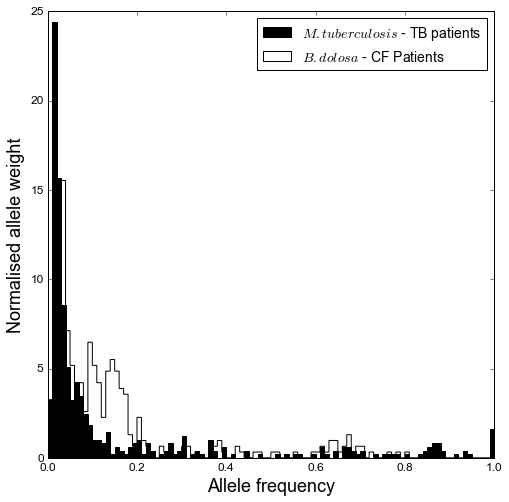

In [9]:
plt.figure('SFS', figsize=(8,8))
plt.hist(np.array(ALL.FREQUENCY[(ALL.TIME<12)]), bins=np.arange(0,1.01,0.01), 
         label=r'$M.tuberculosis$ - TB patients',normed=True, 
         color='black')
plt.hist(np.concatenate(TL_unfixed[:-1]), bins=np.arange(0,1.01,0.01), 
         label=r'$B.dolosa$ - CF Patients',color='black', normed=True, histtype='step')
plt.legend(fontsize=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Allele frequency', size=18)
plt.ylabel('Normalised allele weight', size=18)

#plt.savefig('../reports/figures/JT_SFS_TBCF.pdf')
#plt.savefig('../reports/figures/JT_SFS_TBCF.png',dpi=300)